# Hinton et al, 'Distilling the Knowledge in a Neural Network' (2015)

Original article: https://arxiv.org/abs/1503.02531

**Presentation by:**

**Abhinav Katoch (katoch@uchicago.edu),**

**Javid Lakha (javid.lakha@outlook.com), **

**Sergio Naval  (s.naval.m@gmail.com), **

**Eduard Tuchfeld (eduard.tuchfeld@gmail.com)**

# Introduction

The paper, "Distilling the Knowledge in a Neural Network" (Hinton et al. 2015) develops a methodology to transfer knowledge between classification learning models. Although knowledge transfer between models can be desirable in different practical scenarios, the paper highlights as one of the objectives achieving simpler models that obtain similar performance as cumbersome models or ensamble of specialist models without their computational overhead. 

The strategy to generate this simpler model implies:

(1) Train cumbersome models or ensambles of specialists models that maximize predictivity without taking into account computation cost constraints.

(2) Reutilize knowledge generated by the cumbersome models to train simpler models. Specifically, the knowledge reutilized takes the form of the individual class probabilities. 

Generally the cumbersome model would have been trained with the objective of maximizing the average log probability of the correct class. As a side-effect of the patterns identified, it will also assign probabilities for all the other classes. For example, in a network trained to recognized MNIST written numbers, even if a cumbersome model predicts correctly that a written number is a 7, if the specific number was similar to a 3 the model will assign probability to the 3 class recognizing a pattern between the inputs and the class. 

The destillation techique allows simpler models to utilize this additional information/knowledge generated by the cumbersome model to overperform other models with the same complexity trained using only the class  targets.


# Distillation

As described in the introduction, part of the knowledge generated by the cumbersome models is reflected in the probabilities assigned to each class for each sample. A common approach to assign probabilites to multiple classes is using a softmax layer. The softmax output layer assigns a probability *q* for a class *i* using scores $z_i$ with the following expression: 

$$ q_i = \frac{exp(z_i/T)}{\sum_j exp(z_i/T)}
$$

*T* is a temperature parameter that is generally set to 1 given that higher temperatures will not change the class with higher probability, just produce a softer probability distribution over classes. 

As we know from the lectures on Simulated Annealing, exponentiating a function tends to produce a very peaked output. For example if we have points (1,2,3) in the logit space, in the exponentiated space we get back (2.7, 7.29 and 19.683). Similarly, normalizing in the exponentiated space gives us (8%, 25% and 67% as the probabilities associated with these points) as opposed to (16.6%, 33.33% and 50%) in the logit space. Since the softmax function exponentiates the logits, its effect as an output layer is to exaggerate the value of the most probable class and downplay the probability of the less probable classes. 

This is a problem because in the distillation process we are trying to convey information to the simpler model but if we use the target distribution from the more complex model we are losing some of the knowledge that it actually developed in producing its outputs. By raising the temperature, we decrease the absolute value of the logits being sent into the softmax function and then exponentiate and sum those smaller values. The effect of making the value of the logits smaller is that it pushes the exponentiated class values closer together and hence the proportional differences between the class outputs for a given input becomes closer to linear. 


It is possible to appreciate the impact of the Temperature parameter with an example on written number recognition. The following chart shows the probabilities assigned for each of the classes (0 to 9) depending on the temperature. With a temperature of 1 the model assigns almost all the probability to the 4 class. When the temperature increases, the model assigns an increasing amount of probability to other classes based on the patterns identified that match the class. In this example it can be seen that model assigns probability to 9 class as second most likely option:

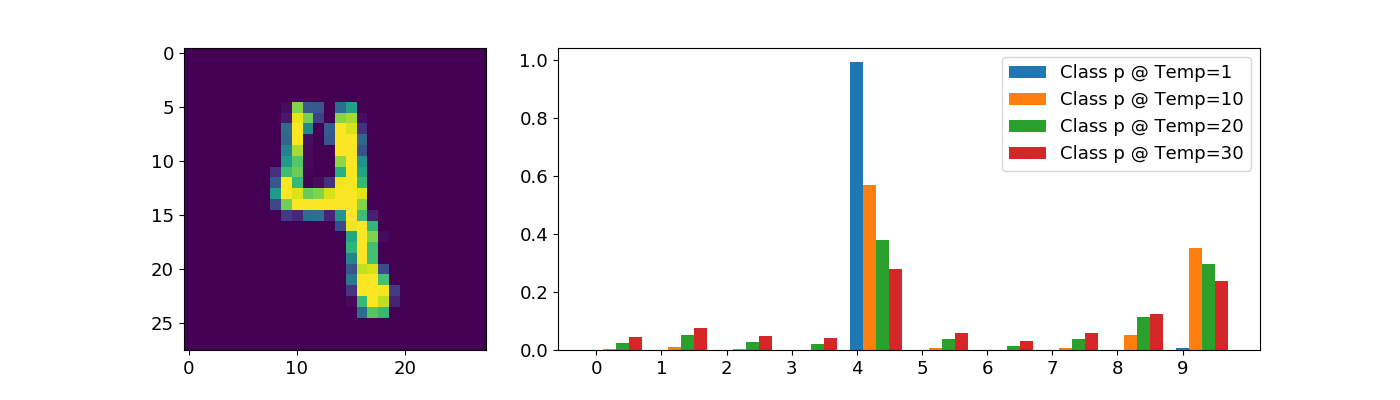

In [2]:
from IPython.display import Image, display
display(Image(filename='four.png', embed=True))

Generally in tasks like MNIST, models achieve an almost perfect classification with high confidence resulting in probabilities very near 1 for the correct class and probabilities in the order of magnitude of 1e-6 or 1e-9 for incorrect classes. By utilizing high temperatures instead of 1, the softmax output layer allow the probabilities to express the knowledge generated by the model in the form of low probabilities assigned to wrong classes. Typical probabilities of MNIST will not express patterns of other classes unless a high temperature is used:

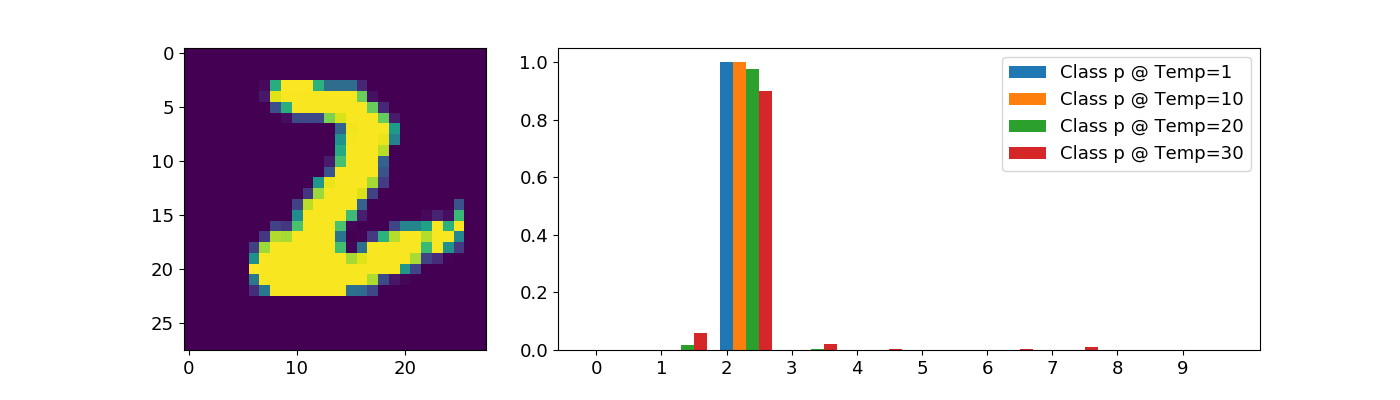

In [3]:
display(Image(filename='two.png', embed=True))

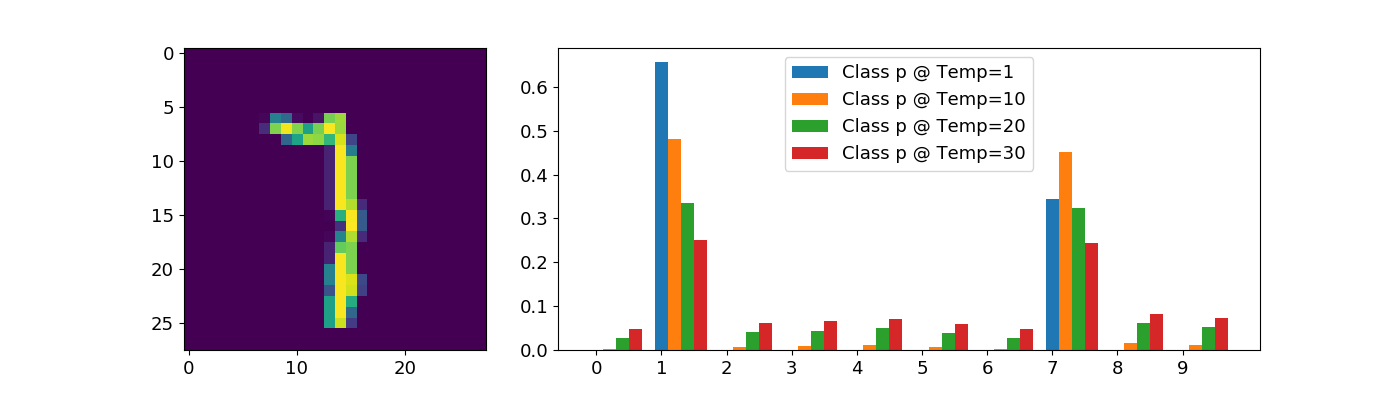

In [2]:
from IPython.display import Image, display
display(Image(filename='seven.png', embed=True))

The "distillation" solution introduced in the paper propose to train the simpler model to match the probabilities generated by the cumbersome model at high temperature as a mechanism to transfer knowledge between the models. The student model is trained with an objective function that combines matching the probabilities (soft targets) and the original class labels (hard targets). 

For the soft target, cross-entropy loss is used between the two sets of probabilites generated at the same temperature. For a task with *i* classes, teacher probabilities *p* (generated by scores *v*) and student probabilities *q* (generated by scores *z*) the *soft* objective is described by the following function:

$$C_{soft} = \sum_i p_i \, log(q_i) = \sum_i \frac{exp(v_i/T)}{\sum_j exp(v_j/T)} log \left( \frac{exp(z_i/T)}{\sum_j exp(z_j/T)} \right)
$$

Each case in the transfer set contributes a cross-entropy gradient, with respect to each score, $z_i$ of the distilled model. This gradient is given by:

$$ \frac{\partial C_{soft}}{\partial z_i} = \frac{1}{T} (q_i-p_i) = \frac{1}{T} \left( \frac{exp(z_i/T)}{\sum_j exp(z_j/T)} - \frac{exp(v_i/T)}{\sum_j exp(v_j/T)} \right)
$$

Cross entropy is also used for the *hard* target (matching true classes). A softmax output layer with temperature 1 is used to match the true class (1 for the true class, 0 for all false classes). 

The paper propose to combine the two cross-entropy using a weighted average. In the implementation of this paper we use a parameter $\alpha$ to regulate the weight in the soft target, the hard target obtaines a weight $1-\alpha$. It is important to note that the magnitude of the $C_{soft}$ gradients are different from the $C_{hard}$ gradients given the different temperature, gradients of soft targets scale as $1/T^2$. Before combining the two objective functions, soft cost needs to be scaled by $T^2$. The total obtective function is defined as:

$$ C = \alpha \, C_{soft} \, T^2 + (1-\alpha) \, C_{hard}
$$

Being the parameters introduced for the distillation:
- T the temperatures in the softmax layer used in soft targets that regulates the expressivity of probabilities generated by teacher model.
- $\alpha$ the weight parameter applied in the soft target

These two parameters will be fitted to specific tasks. 

Below, we implement two Residual Convolutional Neural Networks (ResCNN)  - a "cumbersome" parent network that serves as the teacher and a significantly simpler child network that serves as the student.

The implementations are benchmarked on the **CIFAR-10** image set; **CIFAR-10** was chosen as the appropriate dataset given that is significantly more challenging than the MNIST dataset - allowing us to better differentiate the performance of the parent vs child implementations and knowledge transfer process.


In [5]:
#Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

#TorchVision
import torchvision
import torchvision.transforms as transforms

#Numpy
import numpy as np

#MatplotLib
import matplotlib.pyplot as plt

#System
import os
import sys
import argparse
import time
import copy
from functools import partial
from IPython.display import IFrame, Image, display, clear_output
#GraphGiz for Graph Visualization
try:
    from graphviz import Digraph
except Exception as e:
    print('Cannot Import GraphGiz')
#etc
import re
#
print('PyTorch Version: {}'.format(torch.__version__))

PyTorch Version: 0.4.0


$ \textbf{Prepare Data Loaders} $

In [6]:
#Reference:
#http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#
BATCH_SIZE_TRAIN = 128
#
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) ),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( (0.5, 0.5, 0.5),  (0.5, 0.5, 0.5) ),
])
#
pin_memory = False
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    pin_memory = True
#
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2,
                                          pin_memory=pin_memory)
#
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#
#Test Data Loader
BATCH_SIZE_TEST = 128
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=2, 
                                         pin_memory=pin_memory)

Files already downloaded and verified
Files already downloaded and verified


$ \textbf{Visualizing the Data Set} $

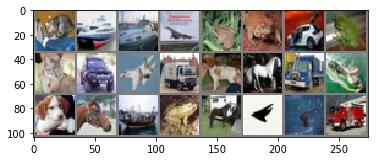

In [10]:
#Reference:
#http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
N = 24
dataiter = iter(testloader)
images, labels = dataiter.next()
images_tmp = images[0:N,:,:]
# show images
imshow(torchvision.utils.make_grid(images_tmp))
plt.figure(figsize=(32*N,32*N))
plt.show()

In [7]:
#LETS VISUALIZE THE NETWORK
#REFERENCE: https://discuss.pytorch.org/t/print-autograd-graph/692/
##
##REQUIRES GRAPHVIZ TO RUN
##
def viz_nn(var, params):
    """ Produces Graphviz representation of PyTorch autograd graph
    """
    try:
        param_map = {id(v): k for k, v in params.items()}
        print(param_map)

        node_attr = dict(style='filled',
                         shape='box',
                         align='left',
                         fontsize='12',
                         ranksep='0.1',
                         height='0.2')
        dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
        seen = set()

        def size_to_str(size):
            return '('+(', ').join(['%d'% v for v in size])+')'

        def add_nodes(var):
            if var not in seen:
                if torch.is_tensor(var):
                    dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
                elif hasattr(var, 'variable'):
                    u = var.variable
                    node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                    dot.node(str(id(var)), node_name, fillcolor='lightblue')
                else:
                    dot.node(str(id(var)), str(type(var).__name__))
                seen.add(var)
                if hasattr(var, 'next_functions'):
                    for u in var.next_functions:
                        if u[0] is not None:
                            dot.edge(str(id(u[0])), str(id(var)))
                            add_nodes(u[0])
                if hasattr(var, 'saved_tensors'):
                    for t in var.saved_tensors:
                        dot.edge(str(id(t)), str(id(var)))
                        add_nodes(t)
        add_nodes(var.grad_fn)
        return dot
    except Exception as e:
        print('viz_nn threw error: {}'.format( e ) )

$ \textbf{ Prepare Auxiliary Functions - Saved Model Loaders, Training Harness } $

In [8]:
def load_model( model, optimizer, dir_path='./checkpoint', model_name='DeepResNet_parent' ):
    '''loads previously saved model into memory'''
    try:
        model_path = dir_path + '/' + model_name
        if torch.cuda.is_available():
            model_path += '_GPU.pth'
            checkpoint = torch.load(model_path)
        else:
            model_path += '.pth'
            checkpoint = torch.load(model_path)
        #
        epoch = checkpoint['epoch']
        optimizer_dict = checkpoint['optimizer']
        optimizer.load_state_dict(optimizer_dict)
        state_dict = checkpoint['state_dict']
        model.load_state_dict(state_dict, strict=False)
        print('learning rate: {}'.format(lr))
        print('initial epoch: {}'.format(epoch))
        return model, optimizer, epoch
    except Exception as e:
        print('[load_model] Exception: {}'.format(e))
        return 0
#

In [9]:
#if you pass just parent_model, then training_harness will train the parent model
#if you pass parent_model AND child_model, then training_harness assumes the parent model is trained
#and we need to train the child model FROM the parent model
#
def training_harness( dataloader, optimizer, loss_func, parent_model, child_model = None, epochs = 51, init_epoch = 0, 
                     model_name = 'DeepResNet', save_every_n_epochs = 10 ):
    '''
    if training child from parent via distillation, loss_func needs to have signature
    (parent_output, labels, child_output)
    '''
    #
    N_EPOCHS = epochs
    train_child_model_from_parent = False
    if child_model is not None:
        model_name += '_child'
        train_child_model_from_parent = True
    else:
        model_name += '_parent'
    #
    #
    for epoch in range( init_epoch, N_EPOCHS ):
        for i, (images, labels) in enumerate(dataloader):
            #
            if torch.cuda.is_available():
                inputs, labels = images.cuda(), labels.cuda()
            #
            images = Variable(images)
            labels = Variable(labels)
            #
            if train_child_model_from_parent:
                parent_probability_dist = parent_model( images )
                parent_probability_dist = Variable( parent_probability_dist, requires_grad=False )
                child_probability_dist  = child_model( images )
                loss = loss_func( child_probability_dist, labels, parent_probability_dist )
            else:
                parent_probability_dist = parent_model( images )
                loss = loss_func( parent_probability_dist, labels )
            #
            optimizer.zero_grad()
            #
            loss.backward()
            #
            optimizer.step()
            #
            if (i+1) % 10 == 0:
                print ("Epoch [%d/%d], Iter [%d/%d] Loss: %.4f" %(epoch+1, N_EPOCHS, i+1, len(trainloader), loss.data[0]))

        #save the model results every 20 epochs
        if (epoch + 1) % int(save_every_n_epochs) == 0:
            #Save Model
            print('\n[Saving Checkpoint]')
            state = {
                'epoch'     : epoch + 1,
                'optimizer' : optimizer.state_dict()
            }
            if train_child_model_from_parent:
                state['state_dict']: child_model.state_dict()
            else:
                state['state_dict']: parent_model.state_dict()
                
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            if torch.cuda.is_available():
                path = './checkpoint' + '/' + model_name + '_GPU.pth'
                torch.save(state, path)
            else:
                path = './checkpoint' + '/' + model_name + '.pth'
                torch.save(state, path)

In [10]:
def test_harness( dataloader, model ):
    correct = 0
    total = 0
    for images, labels in dataloader:
        if torch.cuda.is_available():
            inputs, labels = images.cuda(), labels.cuda()
        images = Variable(images)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the test images: %d %%' % (100 * correct / total))
    return correct, total

# Residual CNN Architecture Overview 
Reference: 

**1. Deep Residual Learning for Image Recognition | Kaiming He et al.  | https://arxiv.org/pdf/1512.03385.pdf**

**2. Convolutional Neural Networks (CNNs / ConvNets) | Stanford CS231N | http://cs231n.github.io/convolutional-networks/**

*PLEASE NOTE: IMAGES ARE TAKEN FROM REFERENCES (1) AND (2) ABOVE*

Convolutional neural networks are deep neural networks which are designed to work with image data (though they can be used for other tasks too - e.g. natural language processing). When working with images, the inputs into a CNN are pixel data, which are structured into matrices if the images are in black and white or into tensors (multidimensional arrays representing the red/green/blue channels - dimension 3) if the images are in colour. Note that a CIFAR-10 image, 32x32 in size, is input as a tensor variable of size [3,32,32] or [$Channels_{in}$, $Width$, $Height$]

The distinguishing feature of convolutional neural networks is the convolutional kernel. These are small (our model uses a standard square 3x3 kernel) matrices and which "slide" across the input tensors and learn to 'pick out' distinguishing features such as edges (a good visual demonstration, in an image processing context, can be found at http://setosa.io/ev/image-kernels/). This approach has an important property: the patterns the kernel learns are translation invariant. Whereas a traditional neural network would have to re-learn a pattern if it appeared at a different location, if a CNN kernel learns a pattern in one part of an image, it will recognise the same pattern everywhere else in the image.

**Below is an illustration from Stanford's CS231N course on how the convolution kernel works.**

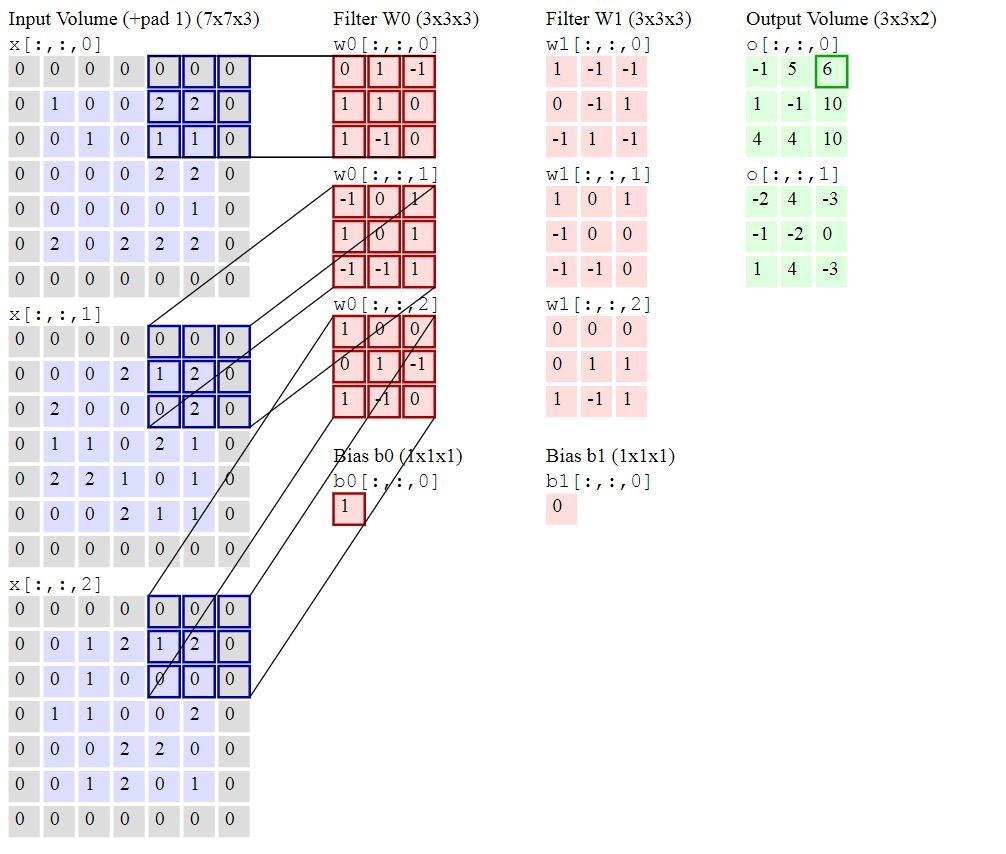

In [35]:
from IPython.display import Image, display
display(Image(filename='convolution_operation.JPG', embed=True, width=500, height=500))
##REFERENCE: http://cs231n.github.io/convolutional-networks/

Convolutional neural networks typically have many layers. This is because they learn patterns hierarchically: for example, the first convolutional layer may learn small patterns such as edges; the second layer may learn larger patterns such an an eye; and third may learn an even larger pattern such as a face. 

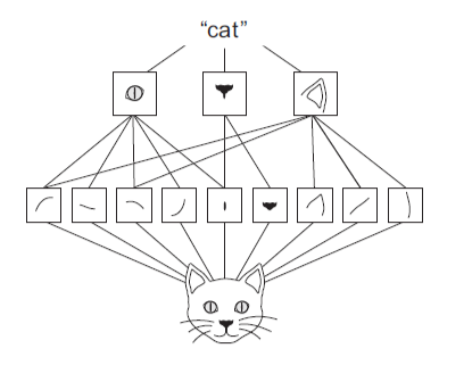

In [37]:
from IPython.display import Image, display
display(Image(filename='CNN cat.png', embed=True, width=300, height=300))

However, whereas a traditional neural network has a comparatively small number of fully connected layers (so that every input interacts with every output), convolutional neural networks typically have sparse connectivity between neurons. This is because meaningful patterns are detected with image kernels. Nonetheless, though sparse connectivity reduces the processing power required, the depth of a convolutional neural network means that it will nonetheless be computationally intensive - often, this means that computations need to be done on dedicated graphics processing units (GPUs) which are optimised for these tasks.

$\textbf{Multi-Layer Perceptrons (MLP) vs Convolutional Neural Networks}$

Previously in the course, we implemented a simple one-hidden layer perceptron network and used it to classify images using the MNIST dataset. So why didn't we use the same architecture on the CIFAR-10 dataset? Well, clearly, a one hidden-layer network was not likely to cut it. CIFAR-10 images are significantly more complex, as visualized above, than the MNIST "hand-written digits" images. There are many more forms a "ship" or an "automobile" can take than a hand-written digit; thus, picking out the distinguishing features is a more complicated task.

So why not implement, a fully connected, deep, multi-layer perceptron? Well, we could - and if we had enough time and training data - it should perform as well or better than the convolutional neural network approach we used. However, by using fully connected layers, we note that there will be 3x32x32 or ~3072 connections (weights) per neuron in the next layer. This approach simply does not scale well with deeper and wider networks or with larger-size input images. Thus, we decided to implement the golden-standard for image recognition: the convolutional neural network!

$\textbf{ Added Residual Modification to the Convolutional Neural Network}$

We implemented a modified convolutional neural network. Specifically, we used the "residual" modification introduced by Kaiming He et al. (2015). Prior to work by Kaiming He et al.at Microsoft Research, deep neural networks used for image recognition suffered from performance degradation. The question then becomes - why should a deep neural network performance worse than a shallower one? Shouldn't the deeper network perform, in the worst case scenario, as bad as the shallower NN? (If the deeper layers simply pass identifical data (identity matrix) from the prior layers downward, then the deeper NN should perform as "bad" as the shallower one). Yet this was not the case, as illustrated below!

**Below Fig 1 Reference: Deep Residual Learning for Image Recognition | Kaiming He et al.  | https://arxiv.org/pdf/1512.03385.pdf**

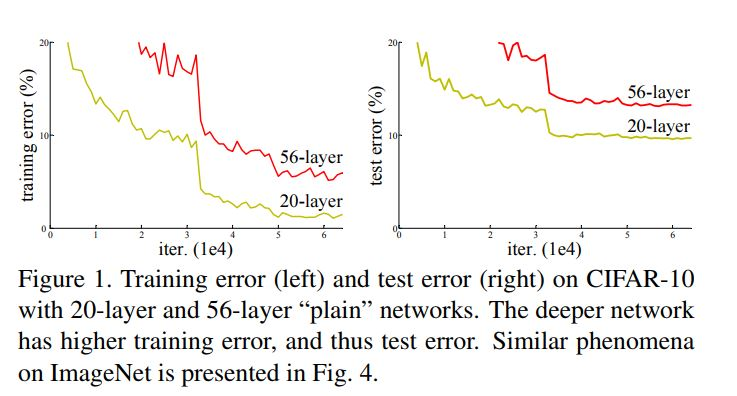

In [38]:
from IPython.display import Image, display
display(Image(filename='deep_res_training_error.JPG', embed=True, width=500, height=500))
#Reference: Deep Residual Learning for Image Recognition | Kaiming He et al.  | https://arxiv.org/pdf/1512.03385.pdf**

The issue, as it happens, lies in the "degradation" problem. Although it is not obvious, what exactly happens as the performance degrades with deep neural networks. As the authors put it, "Unexpectedly, such degradation is not caused by overfitting, and adding more layers to a suitably deep model leads to higher training error." One plausible explanation is that adding additional layers leads to optimization issues - the layers become $\it{harder}$ to train.

The authors of the paper address the issue by introducing $\it{residuals}$ - the idenity of input $\textbf{X}.$ As shown in Fig. 2 below, the residual is added back to the output of the trainable layer within a residual block. As the authors hypothesize, "To the extreme, if an identity mapping were optimal, it would be easier to push
the residual to zero than to fit an identity mapping by a stack of nonlinear layers."

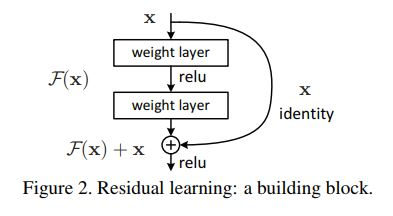

In [40]:
from IPython.display import Image, display
display(Image(filename='residual_building_block.JPG', embed=True, width=300, height=300))
#Reference: Deep Residual Learning for Image Recognition | Kaiming He et al.  | https://arxiv.org/pdf/1512.03385.pdf**

Mathematically, whilst a layer in a traditional neural network is trained to calculate a function F(x), the residual layers of a ResNet are trained to calculate the function F(x) + x. This means that, in theory, increasing depth should not harm a residual neural network, because (in the worst case) the layers can revert to being identity layers.

This architecture in fact proves to be $\textbf{very effective}$ and minimizes the "degradation" problem described above with 100+ layer deep neural networks. Please see Fig. 3 below reference from the paper.

**Below Fig 3 Reference: Deep Residual Learning for Image Recognition | Kaiming He et al.  | https://arxiv.org/pdf/1512.03385.pdf**

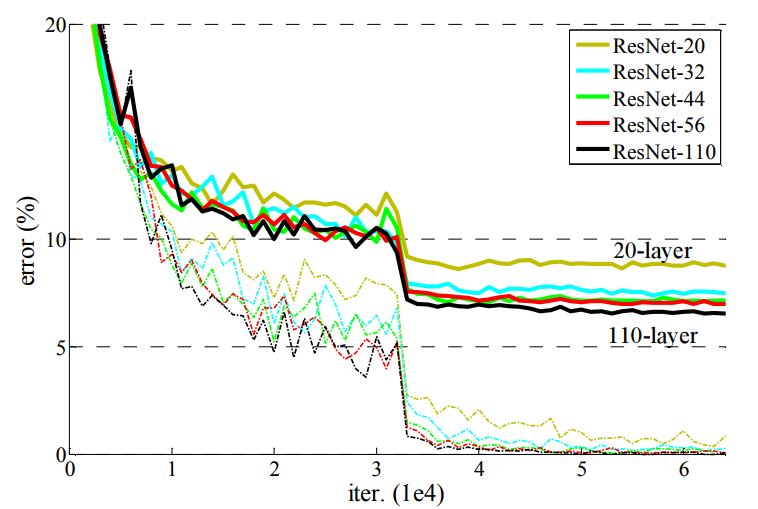

In [45]:
from IPython.display import Image, display
display(Image(filename='deep_res_training_error_with_residuals.JPG', embed=True, width=400, height=400))
#Reference: Deep Residual Learning for Image Recognition | Kaiming He et al.  | https://arxiv.org/pdf/1512.03385.pdf**

# Wide ResNet Parent (Teacher) Model Implementation

In [11]:
#Parent ResNet Implementation Adopted from PyTorch Tutorial
#https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py

#3x3 Convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        #
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        torch.nn.init.xavier_uniform(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        #
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(out_channels)
        #
        self.downsample = downsample

        
    def forward(self, x):
        #
        residual = x
        #
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        #
        out = F.dropout(out, p=0.25)
        #
        out = self.conv2(out)
        out = self.bn2(out)
        #
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        #
        out = self.relu(out)
        #
        return out

# ResNet Module
class WideResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(WideResNet, self).__init__()
        #
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        torch.nn.init.xavier_uniform(self.conv1.weight)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #
        self.layer1 = self.make_layer(block, 160,  layers[0] )
        self.layer2 = self.make_layer(block, 320,  layers[1], 2 )
        self.layer3 = self.make_layer(block, 640,  layers[2], 2 )
        #
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(640, num_classes)
        torch.nn.init.xavier_uniform(self.fc.weight)
       
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            torch.nn.init.xavier_uniform( m.weight )
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
            downsample.apply(self.weights_init)
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        #
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        #
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


$ \textbf{ Graph Visualization of the Wide Residual Parent Network } $

In [16]:
#Uncomment to run visializer (GraphViz)
#m = WideResNet(ResidualBlock, [4,4,4])
#y = m(Variable(images_tmp))
#g = viz_nn(y, m.state_dict())
#IFrame(g.view(), width=1000, height=1000, embed=True)

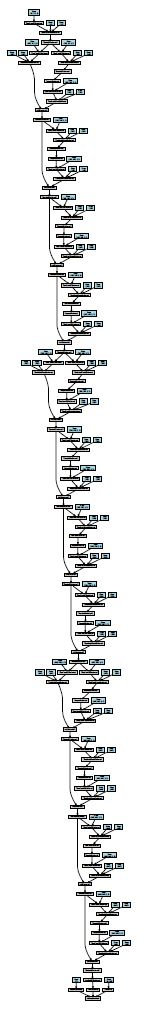

In [3]:
display(Image(filename='res_convnet_parent_graph.JPG', embed=True))

In [12]:
resnet_parent = WideResNet(ResidualBlock, [4,4,4])
learning_rate = 0.01
epoch = 0
optimizer_parent = torch.optim.SGD(resnet_parent.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
#GPU Acceleration
if torch.cuda.is_available():
    gpu_id =  torch.cuda.get_device_name(0)
    print('ENABLING GPU ACCELERATION || {}'.format(gpu_id))
    resnet_parent = torch.nn.DataParallel(resnet_parent, device_ids=range(torch.cuda.device_count()))
    resnet_parent.cuda()
    cudnn.benchmark = True
#Load Previous Model?
load_previous_model = False
if load_previous_model:
    resnet_parent, optimizer_parent, epoch = load_model( resnet_parent, optimizer_parent )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti


In [27]:
#let's train the parent model
#func signature for training_harness:
#dataloader, optimizer, loss_func, parent_model, child_model = None, epochs = 51, init_epoch = 0, 
#model_name = 'DeepResNet', save_every_n_epochs = 10 ):
loss_func = nn.CrossEntropyLoss()
training_harness( trainloader, optimizer_parent, loss_func, resnet_parent )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/51], Iter [10/391] Loss: 2.0253
Epoch [1/51], Iter [20/391] Loss: 1.9886
Epoch [1/51], Iter [30/391] Loss: 2.0261
Epoch [1/51], Iter [40/391] Loss: 1.8313
Epoch [1/51], Iter [50/391] Loss: 1.7924
Epoch [1/51], Iter [60/391] Loss: 1.6717
Epoch [1/51], Iter [70/391] Loss: 1.6798
Epoch [1/51], Iter [80/391] Loss: 1.7018
Epoch [1/51], Iter [90/391] Loss: 1.5539
Epoch [1/51], Iter [100/391] Loss: 1.5560
Epoch [1/51], Iter [110/391] Loss: 1.4972
Epoch [1/51], Iter [120/391] Loss: 1.4055
Epoch [1/51], Iter [130/391] Loss: 1.4232
Epoch [1/51], Iter [140/391] Loss: 1.4804
Epoch [1/51], Iter [150/391] Loss: 1.4402
Epoch [1/51], Iter [160/391] Loss: 1.4663
Epoch [1/51], Iter [170/391] Loss: 1.4200
Epoch [1/51], Iter [180/391] Loss: 1.3065
Epoch [1/51], Iter [190/391] Loss: 1.2539
Epoch [1/51], Iter [200/391] Loss: 1.3325
Epoch [1/51], Iter [210/391] Loss: 1.2613
Epoch [1/51], Iter [220/391] Loss: 1.2503
Epoch [1/51], Iter [230/391] Loss: 1.3215
Epoch [1/51], Iter [240/391] Loss: 1.1664
E

Epoch [11/51], Iter [10/391] Loss: 0.2828
Epoch [11/51], Iter [20/391] Loss: 0.1861
Epoch [11/51], Iter [30/391] Loss: 0.1897
Epoch [11/51], Iter [40/391] Loss: 0.2999
Epoch [11/51], Iter [50/391] Loss: 0.1270
Epoch [11/51], Iter [60/391] Loss: 0.2406
Epoch [11/51], Iter [70/391] Loss: 0.1170
Epoch [11/51], Iter [80/391] Loss: 0.3510
Epoch [11/51], Iter [90/391] Loss: 0.2706
Epoch [11/51], Iter [100/391] Loss: 0.2945
Epoch [11/51], Iter [110/391] Loss: 0.1949
Epoch [11/51], Iter [120/391] Loss: 0.1371
Epoch [11/51], Iter [130/391] Loss: 0.1880
Epoch [11/51], Iter [140/391] Loss: 0.2691
Epoch [11/51], Iter [150/391] Loss: 0.2978
Epoch [11/51], Iter [160/391] Loss: 0.2500
Epoch [11/51], Iter [170/391] Loss: 0.5706
Epoch [11/51], Iter [180/391] Loss: 0.2087
Epoch [11/51], Iter [190/391] Loss: 0.2218
Epoch [11/51], Iter [200/391] Loss: 0.2162
Epoch [11/51], Iter [210/391] Loss: 0.2666
Epoch [11/51], Iter [220/391] Loss: 0.1812
Epoch [11/51], Iter [230/391] Loss: 0.3489
Epoch [11/51], Iter 

Epoch [20/51], Iter [320/391] Loss: 0.1779
Epoch [20/51], Iter [330/391] Loss: 0.1721
Epoch [20/51], Iter [340/391] Loss: 0.1864
Epoch [20/51], Iter [350/391] Loss: 0.1653
Epoch [20/51], Iter [360/391] Loss: 0.1375
Epoch [20/51], Iter [370/391] Loss: 0.1724
Epoch [20/51], Iter [380/391] Loss: 0.1294
Epoch [20/51], Iter [390/391] Loss: 0.0644

[Saving Checkpoint]
Epoch [21/51], Iter [10/391] Loss: 0.2098
Epoch [21/51], Iter [20/391] Loss: 0.0959
Epoch [21/51], Iter [30/391] Loss: 0.0609
Epoch [21/51], Iter [40/391] Loss: 0.1194
Epoch [21/51], Iter [50/391] Loss: 0.0659
Epoch [21/51], Iter [60/391] Loss: 0.1811
Epoch [21/51], Iter [70/391] Loss: 0.1467
Epoch [21/51], Iter [80/391] Loss: 0.0762
Epoch [21/51], Iter [90/391] Loss: 0.1073
Epoch [21/51], Iter [100/391] Loss: 0.0679
Epoch [21/51], Iter [110/391] Loss: 0.0820
Epoch [21/51], Iter [120/391] Loss: 0.0492
Epoch [21/51], Iter [130/391] Loss: 0.0976
Epoch [21/51], Iter [140/391] Loss: 0.1319
Epoch [21/51], Iter [150/391] Loss: 0.1302

Epoch [30/51], Iter [240/391] Loss: 0.0949
Epoch [30/51], Iter [250/391] Loss: 0.0669
Epoch [30/51], Iter [260/391] Loss: 0.1003
Epoch [30/51], Iter [270/391] Loss: 0.0562
Epoch [30/51], Iter [280/391] Loss: 0.0847
Epoch [30/51], Iter [290/391] Loss: 0.1165
Epoch [30/51], Iter [300/391] Loss: 0.0930
Epoch [30/51], Iter [310/391] Loss: 0.0676
Epoch [30/51], Iter [320/391] Loss: 0.0535
Epoch [30/51], Iter [330/391] Loss: 0.0841
Epoch [30/51], Iter [340/391] Loss: 0.0584
Epoch [30/51], Iter [350/391] Loss: 0.0735
Epoch [30/51], Iter [360/391] Loss: 0.0680
Epoch [30/51], Iter [370/391] Loss: 0.0586
Epoch [30/51], Iter [380/391] Loss: 0.2232
Epoch [30/51], Iter [390/391] Loss: 0.1169

[Saving Checkpoint]
Epoch [31/51], Iter [10/391] Loss: 0.1015
Epoch [31/51], Iter [20/391] Loss: 0.0555
Epoch [31/51], Iter [30/391] Loss: 0.0684
Epoch [31/51], Iter [40/391] Loss: 0.0662
Epoch [31/51], Iter [50/391] Loss: 0.0436
Epoch [31/51], Iter [60/391] Loss: 0.0820
Epoch [31/51], Iter [70/391] Loss: 0.04

Epoch [40/51], Iter [160/391] Loss: 0.0725
Epoch [40/51], Iter [170/391] Loss: 0.1238
Epoch [40/51], Iter [180/391] Loss: 0.0612
Epoch [40/51], Iter [190/391] Loss: 0.1162
Epoch [40/51], Iter [200/391] Loss: 0.0872
Epoch [40/51], Iter [210/391] Loss: 0.0359
Epoch [40/51], Iter [220/391] Loss: 0.0851
Epoch [40/51], Iter [230/391] Loss: 0.0384
Epoch [40/51], Iter [240/391] Loss: 0.0222
Epoch [40/51], Iter [250/391] Loss: 0.0516
Epoch [40/51], Iter [260/391] Loss: 0.1032
Epoch [40/51], Iter [270/391] Loss: 0.0540
Epoch [40/51], Iter [280/391] Loss: 0.0399
Epoch [40/51], Iter [290/391] Loss: 0.0278
Epoch [40/51], Iter [300/391] Loss: 0.0641
Epoch [40/51], Iter [310/391] Loss: 0.0517
Epoch [40/51], Iter [320/391] Loss: 0.0449
Epoch [40/51], Iter [330/391] Loss: 0.0435
Epoch [40/51], Iter [340/391] Loss: 0.1057
Epoch [40/51], Iter [350/391] Loss: 0.0940
Epoch [40/51], Iter [360/391] Loss: 0.0455
Epoch [40/51], Iter [370/391] Loss: 0.0763
Epoch [40/51], Iter [380/391] Loss: 0.0495
Epoch [40/5

Epoch [50/51], Iter [80/391] Loss: 0.0213
Epoch [50/51], Iter [90/391] Loss: 0.0453
Epoch [50/51], Iter [100/391] Loss: 0.0188
Epoch [50/51], Iter [110/391] Loss: 0.0576
Epoch [50/51], Iter [120/391] Loss: 0.0300
Epoch [50/51], Iter [130/391] Loss: 0.0273
Epoch [50/51], Iter [140/391] Loss: 0.0800
Epoch [50/51], Iter [150/391] Loss: 0.0333
Epoch [50/51], Iter [160/391] Loss: 0.0425
Epoch [50/51], Iter [170/391] Loss: 0.0326
Epoch [50/51], Iter [180/391] Loss: 0.0169
Epoch [50/51], Iter [190/391] Loss: 0.0319
Epoch [50/51], Iter [200/391] Loss: 0.0200
Epoch [50/51], Iter [210/391] Loss: 0.0160
Epoch [50/51], Iter [220/391] Loss: 0.0146
Epoch [50/51], Iter [230/391] Loss: 0.0265
Epoch [50/51], Iter [240/391] Loss: 0.0651
Epoch [50/51], Iter [250/391] Loss: 0.0198
Epoch [50/51], Iter [260/391] Loss: 0.0248
Epoch [50/51], Iter [270/391] Loss: 0.0465
Epoch [50/51], Iter [280/391] Loss: 0.0790
Epoch [50/51], Iter [290/391] Loss: 0.0768
Epoch [50/51], Iter [300/391] Loss: 0.0104
Epoch [50/51]

In [28]:
 test_harness( testloader, resnet_parent )

Accuracy of the model on the test images: 91 %


(tensor(9143, device='cuda:0'), 10000)

# ResNet Child (Student) Model Implementation 

In [13]:
# ResNet Module
##NOTE:
##Uses the same 'Residual Block' as the parent model; however, the child model is shallower and not as wide
##computationally much faster to train and deploy than the parent
##
class ResNetChild(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNetChild, self).__init__()
        #
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        torch.nn.init.xavier_uniform(self.conv1.weight)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #
        self.layer1 = self.make_layer(block, 160,  layers[0] )
        self.layer2 = self.make_layer(block, 320,  layers[1], 2 )
        #
        self.avg_pool = nn.AvgPool2d(16)
        self.fc = nn.Linear(320, num_classes)
        torch.nn.init.xavier_uniform(self.fc.weight)
       
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            torch.nn.init.xavier_uniform( m.weight )
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
            downsample.apply(self.weights_init)
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        #
        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)
        #
        out = self.layer1(out)
        out = self.layer2(out)
        #
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [17]:
#Uncomment to run visializer (GraphViz)
#m = ResNetChild(ResidualBlock, [2,2])
#y = m(Variable(images_tmp))
#g_child = viz_nn(y, m.state_dict())
#IFrame(g_child.view(), width=1000, height=1000, embed=True)

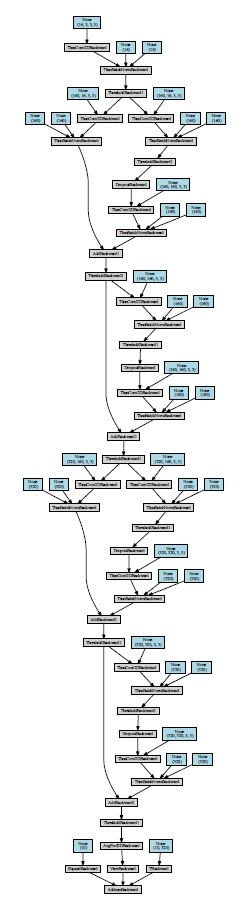

In [4]:
display(Image(filename='res_convnet_child_graph.JPG', embed=True))

In [17]:
#helper function to get back a new child (student) model
def get_new_child_model( block = ResidualBlock, layers = [2, 2], learning_rate = 0.01 ):
    resnet_child = ResNetChild( block, layers )
    optimizer_child = torch.optim.SGD(resnet_child.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    #GPU Acceleration
    if torch.cuda.is_available():
        gpu_id =  torch.cuda.get_device_name(0)
        print('ENABLING GPU ACCELERATION || {}'.format(gpu_id))
        resnet_child = torch.nn.DataParallel(resnet_child, device_ids=range(torch.cuda.device_count()))
        resnet_child.cuda()
        cudnn.benchmark = True
    return resnet_child, optimizer_child

In [58]:
resnet_child, optimizer_child = get_new_child_model()
epoch = 0
#Load Previous Model?
load_previous_model = False
if load_previous_model:
    resnet_child, optimizer_child, epoch = load_model( resnet_child, optimizer_child )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti


# "Knowledge Distillation" Cost Function Implementation

Below we implement the "knowledge distillation" cost function. The cost function is a linear combination of KL divergence and Cross Entropy loss.

To compare the outputs for 'hard targets,' we use the Cross Entropy loss that is already implemented in PyTorch; the implementation incorporates a Soft-Max layer followed by an an 'Cross-Entropy' calculcation given the hard target (labels).

For the soft objective function we will instead use the KL divergence loss implementation; the KL divergence function as implemented in PyTorch uses target class probabilities. KL divergence is the difference between the cross-entropy P,Q and the entropy of P:

$$D_{KL}(P \vert\vert Q) = -\sum_i P(i) \, log \frac{Q(i)}{P(i)} = \sum_i P(i) \, log P(i) -\sum_i P(i) \, log Q(i) = H(P,Q) - H(P)
$$

Given that entropy of P (soft targets generated by teacher model) does not depend on logits z (student model), using KL divergence instead of cross entropy will not have an impact on the gradients and we can utilize the scaling between the two losses described in the paper.

$$\frac{\partial D_{KL}}{\partial z_i} = \frac{\partial H(P,Q)}{\partial z_i}
$$


In [50]:
#Knowledge Distillation Loss Function
def knowledge_distillation_loss( student_output, labels, teacher_output, alpha, T ):
    ''' '''
    student_output_pr = F.log_softmax(student_output, dim=1)
    teacher_output_pr = F.softmax(teacher_output/T, dim=1)
    #
    loss_func = nn.KLDivLoss()
    #
    loss = loss_func( student_output_pr, teacher_output_pr ) * alpha  * (T * T) #(T*T for gradient scaling)
    loss = loss + F.cross_entropy(student_output, labels) * (1. - alpha)
    #
    return loss


Note that the PyTorch *KLDivLoss* implementation takes as input:

- Outputs - Log probabilities for each class (note F.log_softmax instead of F.softmax) 
- Targets - Probabilites of each class, in the distillation implementation these are generated by teacher model.
    
Cross Entropy PyTorch implementation *F.cross_entropy* takes as inputs directly the scores (logits) before applying the Soft-Max layer and labels:

In [51]:
#let's train the child (student) model
#we can define different knowledge distillation (KD) functions by binding alpha and temperature like this 
#alpha = 0, T=1 (as represented by a0_t1) means child network learns from 'labels' - not from parent.
#this is the baseline scenario
kd_loss_a0_t1 = partial( knowledge_distillation_loss, alpha=0, T=1 ) 
training_harness( trainloader, optimizer_child, kd_loss_a0_t1, resnet_parent, resnet_child )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/51], Iter [10/391] Loss: 2.2543
Epoch [1/51], Iter [20/391] Loss: 1.9698
Epoch [1/51], Iter [30/391] Loss: 1.8502
Epoch [1/51], Iter [40/391] Loss: 1.7565
Epoch [1/51], Iter [50/391] Loss: 1.7479
Epoch [1/51], Iter [60/391] Loss: 1.6707
Epoch [1/51], Iter [70/391] Loss: 1.8412
Epoch [1/51], Iter [80/391] Loss: 1.6146
Epoch [1/51], Iter [90/391] Loss: 1.7598
Epoch [1/51], Iter [100/391] Loss: 1.5648
Epoch [1/51], Iter [110/391] Loss: 1.5721
Epoch [1/51], Iter [120/391] Loss: 1.6673
Epoch [1/51], Iter [130/391] Loss: 1.5275
Epoch [1/51], Iter [140/391] Loss: 1.4643
Epoch [1/51], Iter [150/391] Loss: 1.6041
Epoch [1/51], Iter [160/391] Loss: 1.5165
Epoch [1/51], Iter [170/391] Loss: 1.4318
Epoch [1/51], Iter [180/391] Loss: 1.5028
Epoch [1/51], Iter [190/391] Loss: 1.3602
Epoch [1/51], Iter [200/391] Loss: 1.5109
Epoch [1/51], Iter [210/391] Loss: 1.2951
Epoch [1/51], Iter [220/391] Loss: 1.3385
Epoch [1/51], Iter [230/391] Loss: 1.3036
Epoch [1/51], Iter [240/391] Loss: 1.2850
E

Epoch [11/51], Iter [10/391] Loss: 0.2423
Epoch [11/51], Iter [20/391] Loss: 0.3662
Epoch [11/51], Iter [30/391] Loss: 0.4482
Epoch [11/51], Iter [40/391] Loss: 0.3433
Epoch [11/51], Iter [50/391] Loss: 0.4427
Epoch [11/51], Iter [60/391] Loss: 0.3703
Epoch [11/51], Iter [70/391] Loss: 0.4209
Epoch [11/51], Iter [80/391] Loss: 0.3447
Epoch [11/51], Iter [90/391] Loss: 0.3864
Epoch [11/51], Iter [100/391] Loss: 0.3484
Epoch [11/51], Iter [110/391] Loss: 0.4563
Epoch [11/51], Iter [120/391] Loss: 0.5370
Epoch [11/51], Iter [130/391] Loss: 0.5135
Epoch [11/51], Iter [140/391] Loss: 0.3203
Epoch [11/51], Iter [150/391] Loss: 0.3630
Epoch [11/51], Iter [160/391] Loss: 0.6241
Epoch [11/51], Iter [170/391] Loss: 0.4407
Epoch [11/51], Iter [180/391] Loss: 0.4519
Epoch [11/51], Iter [190/391] Loss: 0.4971
Epoch [11/51], Iter [200/391] Loss: 0.4521
Epoch [11/51], Iter [210/391] Loss: 0.3455
Epoch [11/51], Iter [220/391] Loss: 0.3956
Epoch [11/51], Iter [230/391] Loss: 0.3820
Epoch [11/51], Iter 

Epoch [20/51], Iter [320/391] Loss: 0.1832
Epoch [20/51], Iter [330/391] Loss: 0.2309
Epoch [20/51], Iter [340/391] Loss: 0.2052
Epoch [20/51], Iter [350/391] Loss: 0.1681
Epoch [20/51], Iter [360/391] Loss: 0.2561
Epoch [20/51], Iter [370/391] Loss: 0.2353
Epoch [20/51], Iter [380/391] Loss: 0.2479
Epoch [20/51], Iter [390/391] Loss: 0.2421

[Saving Checkpoint]
Epoch [21/51], Iter [10/391] Loss: 0.2840
Epoch [21/51], Iter [20/391] Loss: 0.1539
Epoch [21/51], Iter [30/391] Loss: 0.1729
Epoch [21/51], Iter [40/391] Loss: 0.2907
Epoch [21/51], Iter [50/391] Loss: 0.2068
Epoch [21/51], Iter [60/391] Loss: 0.2832
Epoch [21/51], Iter [70/391] Loss: 0.2043
Epoch [21/51], Iter [80/391] Loss: 0.1719
Epoch [21/51], Iter [90/391] Loss: 0.2159
Epoch [21/51], Iter [100/391] Loss: 0.2655
Epoch [21/51], Iter [110/391] Loss: 0.2289
Epoch [21/51], Iter [120/391] Loss: 0.3018
Epoch [21/51], Iter [130/391] Loss: 0.3564
Epoch [21/51], Iter [140/391] Loss: 0.3097
Epoch [21/51], Iter [150/391] Loss: 0.1708

Epoch [30/51], Iter [240/391] Loss: 0.1581
Epoch [30/51], Iter [250/391] Loss: 0.1839
Epoch [30/51], Iter [260/391] Loss: 0.1493
Epoch [30/51], Iter [270/391] Loss: 0.1740
Epoch [30/51], Iter [280/391] Loss: 0.2307
Epoch [30/51], Iter [290/391] Loss: 0.1929
Epoch [30/51], Iter [300/391] Loss: 0.1820
Epoch [30/51], Iter [310/391] Loss: 0.1900
Epoch [30/51], Iter [320/391] Loss: 0.1207
Epoch [30/51], Iter [330/391] Loss: 0.1436
Epoch [30/51], Iter [340/391] Loss: 0.1504
Epoch [30/51], Iter [350/391] Loss: 0.2274
Epoch [30/51], Iter [360/391] Loss: 0.2147
Epoch [30/51], Iter [370/391] Loss: 0.1882
Epoch [30/51], Iter [380/391] Loss: 0.1941
Epoch [30/51], Iter [390/391] Loss: 0.1888

[Saving Checkpoint]
Epoch [31/51], Iter [10/391] Loss: 0.1019
Epoch [31/51], Iter [20/391] Loss: 0.0967
Epoch [31/51], Iter [30/391] Loss: 0.0966
Epoch [31/51], Iter [40/391] Loss: 0.1501
Epoch [31/51], Iter [50/391] Loss: 0.1462
Epoch [31/51], Iter [60/391] Loss: 0.1327
Epoch [31/51], Iter [70/391] Loss: 0.12

Epoch [40/51], Iter [160/391] Loss: 0.0900
Epoch [40/51], Iter [170/391] Loss: 0.1431
Epoch [40/51], Iter [180/391] Loss: 0.1003
Epoch [40/51], Iter [190/391] Loss: 0.1131
Epoch [40/51], Iter [200/391] Loss: 0.1043
Epoch [40/51], Iter [210/391] Loss: 0.0834
Epoch [40/51], Iter [220/391] Loss: 0.1855
Epoch [40/51], Iter [230/391] Loss: 0.1044
Epoch [40/51], Iter [240/391] Loss: 0.0953
Epoch [40/51], Iter [250/391] Loss: 0.1267
Epoch [40/51], Iter [260/391] Loss: 0.0966
Epoch [40/51], Iter [270/391] Loss: 0.0858
Epoch [40/51], Iter [280/391] Loss: 0.0621
Epoch [40/51], Iter [290/391] Loss: 0.0803
Epoch [40/51], Iter [300/391] Loss: 0.1052
Epoch [40/51], Iter [310/391] Loss: 0.0860
Epoch [40/51], Iter [320/391] Loss: 0.1120
Epoch [40/51], Iter [330/391] Loss: 0.1128
Epoch [40/51], Iter [340/391] Loss: 0.0746
Epoch [40/51], Iter [350/391] Loss: 0.0920
Epoch [40/51], Iter [360/391] Loss: 0.1423
Epoch [40/51], Iter [370/391] Loss: 0.1035
Epoch [40/51], Iter [380/391] Loss: 0.1689
Epoch [40/5

Epoch [50/51], Iter [80/391] Loss: 0.0539
Epoch [50/51], Iter [90/391] Loss: 0.0441
Epoch [50/51], Iter [100/391] Loss: 0.0802
Epoch [50/51], Iter [110/391] Loss: 0.0746
Epoch [50/51], Iter [120/391] Loss: 0.0696
Epoch [50/51], Iter [130/391] Loss: 0.1012
Epoch [50/51], Iter [140/391] Loss: 0.1286
Epoch [50/51], Iter [150/391] Loss: 0.1165
Epoch [50/51], Iter [160/391] Loss: 0.1265
Epoch [50/51], Iter [170/391] Loss: 0.0583
Epoch [50/51], Iter [180/391] Loss: 0.0702
Epoch [50/51], Iter [190/391] Loss: 0.0446
Epoch [50/51], Iter [200/391] Loss: 0.0902
Epoch [50/51], Iter [210/391] Loss: 0.1049
Epoch [50/51], Iter [220/391] Loss: 0.0396
Epoch [50/51], Iter [230/391] Loss: 0.0605
Epoch [50/51], Iter [240/391] Loss: 0.1211
Epoch [50/51], Iter [250/391] Loss: 0.0460
Epoch [50/51], Iter [260/391] Loss: 0.0752
Epoch [50/51], Iter [270/391] Loss: 0.0511
Epoch [50/51], Iter [280/391] Loss: 0.0796
Epoch [50/51], Iter [290/391] Loss: 0.0432
Epoch [50/51], Iter [300/391] Loss: 0.0655
Epoch [50/51]

In [52]:
# | a=0 | T=1 | epochs = 51 | 
test_harness( testloader, resnet_child )

Accuracy of the model on the test images: 88 %


(tensor(8859, device='cuda:0'), 10000)

In [55]:
resnet_child_a0_t1_e51 = copy.deepcopy(resnet_child) #let's save for future reference

In [61]:
# | a=1 | T=5 | epochs = 51 | 
resnet_child, optimizer_child = get_new_child_model()
epoch = 0
kd_loss_a1_t5 = partial( knowledge_distillation_loss, alpha=1, T=5 ) 
training_harness( trainloader, optimizer_child, kd_loss_a1_t5, resnet_parent, resnet_child, model_name='DeepResNet_a1_t5_e51' )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti


C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/51], Iter [10/391] Loss: 1.5539
Epoch [1/51], Iter [20/391] Loss: 1.2895
Epoch [1/51], Iter [30/391] Loss: 1.2595
Epoch [1/51], Iter [40/391] Loss: 1.0947
Epoch [1/51], Iter [50/391] Loss: 1.2370
Epoch [1/51], Iter [60/391] Loss: 1.1683
Epoch [1/51], Iter [70/391] Loss: 1.1829
Epoch [1/51], Iter [80/391] Loss: 1.1049
Epoch [1/51], Iter [90/391] Loss: 1.0549
Epoch [1/51], Iter [100/391] Loss: 1.1035
Epoch [1/51], Iter [110/391] Loss: 0.9451
Epoch [1/51], Iter [120/391] Loss: 1.0377
Epoch [1/51], Iter [130/391] Loss: 1.0612
Epoch [1/51], Iter [140/391] Loss: 0.8896
Epoch [1/51], Iter [150/391] Loss: 1.0050
Epoch [1/51], Iter [160/391] Loss: 0.9043
Epoch [1/51], Iter [170/391] Loss: 0.9472
Epoch [1/51], Iter [180/391] Loss: 0.8607
Epoch [1/51], Iter [190/391] Loss: 0.8388
Epoch [1/51], Iter [200/391] Loss: 0.8349
Epoch [1/51], Iter [210/391] Loss: 0.8813
Epoch [1/51], Iter [220/391] Loss: 0.7765
Epoch [1/51], Iter [230/391] Loss: 0.8249
Epoch [1/51], Iter [240/391] Loss: 0.7388
E

Epoch [11/51], Iter [10/391] Loss: 0.2014
Epoch [11/51], Iter [20/391] Loss: 0.2127
Epoch [11/51], Iter [30/391] Loss: 0.2101
Epoch [11/51], Iter [40/391] Loss: 0.2286
Epoch [11/51], Iter [50/391] Loss: 0.2047
Epoch [11/51], Iter [60/391] Loss: 0.1956
Epoch [11/51], Iter [70/391] Loss: 0.2313
Epoch [11/51], Iter [80/391] Loss: 0.2087
Epoch [11/51], Iter [90/391] Loss: 0.2058
Epoch [11/51], Iter [100/391] Loss: 0.2050
Epoch [11/51], Iter [110/391] Loss: 0.2416
Epoch [11/51], Iter [120/391] Loss: 0.2077
Epoch [11/51], Iter [130/391] Loss: 0.1983
Epoch [11/51], Iter [140/391] Loss: 0.1847
Epoch [11/51], Iter [150/391] Loss: 0.1942
Epoch [11/51], Iter [160/391] Loss: 0.2070
Epoch [11/51], Iter [170/391] Loss: 0.1982
Epoch [11/51], Iter [180/391] Loss: 0.1797
Epoch [11/51], Iter [190/391] Loss: 0.2037
Epoch [11/51], Iter [200/391] Loss: 0.2056
Epoch [11/51], Iter [210/391] Loss: 0.2210
Epoch [11/51], Iter [220/391] Loss: 0.1900
Epoch [11/51], Iter [230/391] Loss: 0.2051
Epoch [11/51], Iter 

Epoch [20/51], Iter [320/391] Loss: 0.1417
Epoch [20/51], Iter [330/391] Loss: 0.1477
Epoch [20/51], Iter [340/391] Loss: 0.1191
Epoch [20/51], Iter [350/391] Loss: 0.1489
Epoch [20/51], Iter [360/391] Loss: 0.1097
Epoch [20/51], Iter [370/391] Loss: 0.1360
Epoch [20/51], Iter [380/391] Loss: 0.1299
Epoch [20/51], Iter [390/391] Loss: 0.1255

[Saving Checkpoint]
Epoch [21/51], Iter [10/391] Loss: 0.1230
Epoch [21/51], Iter [20/391] Loss: 0.1174
Epoch [21/51], Iter [30/391] Loss: 0.1273
Epoch [21/51], Iter [40/391] Loss: 0.1150
Epoch [21/51], Iter [50/391] Loss: 0.1431
Epoch [21/51], Iter [60/391] Loss: 0.1655
Epoch [21/51], Iter [70/391] Loss: 0.1142
Epoch [21/51], Iter [80/391] Loss: 0.1256
Epoch [21/51], Iter [90/391] Loss: 0.1066
Epoch [21/51], Iter [100/391] Loss: 0.1031
Epoch [21/51], Iter [110/391] Loss: 0.1069
Epoch [21/51], Iter [120/391] Loss: 0.1227
Epoch [21/51], Iter [130/391] Loss: 0.1385
Epoch [21/51], Iter [140/391] Loss: 0.1310
Epoch [21/51], Iter [150/391] Loss: 0.1122

Epoch [30/51], Iter [240/391] Loss: 0.1004
Epoch [30/51], Iter [250/391] Loss: 0.0922
Epoch [30/51], Iter [260/391] Loss: 0.1099
Epoch [30/51], Iter [270/391] Loss: 0.0925
Epoch [30/51], Iter [280/391] Loss: 0.0894
Epoch [30/51], Iter [290/391] Loss: 0.0995
Epoch [30/51], Iter [300/391] Loss: 0.0979
Epoch [30/51], Iter [310/391] Loss: 0.0919
Epoch [30/51], Iter [320/391] Loss: 0.0770
Epoch [30/51], Iter [330/391] Loss: 0.0828
Epoch [30/51], Iter [340/391] Loss: 0.1080
Epoch [30/51], Iter [350/391] Loss: 0.0794
Epoch [30/51], Iter [360/391] Loss: 0.0808
Epoch [30/51], Iter [370/391] Loss: 0.1118
Epoch [30/51], Iter [380/391] Loss: 0.0737
Epoch [30/51], Iter [390/391] Loss: 0.0941

[Saving Checkpoint]
Epoch [31/51], Iter [10/391] Loss: 0.0783
Epoch [31/51], Iter [20/391] Loss: 0.0770
Epoch [31/51], Iter [30/391] Loss: 0.0782
Epoch [31/51], Iter [40/391] Loss: 0.0743
Epoch [31/51], Iter [50/391] Loss: 0.0911
Epoch [31/51], Iter [60/391] Loss: 0.0815
Epoch [31/51], Iter [70/391] Loss: 0.09

Epoch [40/51], Iter [160/391] Loss: 0.0832
Epoch [40/51], Iter [170/391] Loss: 0.0659
Epoch [40/51], Iter [180/391] Loss: 0.0754
Epoch [40/51], Iter [190/391] Loss: 0.0785
Epoch [40/51], Iter [200/391] Loss: 0.0783
Epoch [40/51], Iter [210/391] Loss: 0.0727
Epoch [40/51], Iter [220/391] Loss: 0.0791
Epoch [40/51], Iter [230/391] Loss: 0.0681
Epoch [40/51], Iter [240/391] Loss: 0.0624
Epoch [40/51], Iter [250/391] Loss: 0.0885
Epoch [40/51], Iter [260/391] Loss: 0.0865
Epoch [40/51], Iter [270/391] Loss: 0.0726
Epoch [40/51], Iter [280/391] Loss: 0.0801
Epoch [40/51], Iter [290/391] Loss: 0.0696
Epoch [40/51], Iter [300/391] Loss: 0.0728
Epoch [40/51], Iter [310/391] Loss: 0.0579
Epoch [40/51], Iter [320/391] Loss: 0.0838
Epoch [40/51], Iter [330/391] Loss: 0.0682
Epoch [40/51], Iter [340/391] Loss: 0.0792
Epoch [40/51], Iter [350/391] Loss: 0.0868
Epoch [40/51], Iter [360/391] Loss: 0.0812
Epoch [40/51], Iter [370/391] Loss: 0.0688
Epoch [40/51], Iter [380/391] Loss: 0.0755
Epoch [40/5

Epoch [50/51], Iter [80/391] Loss: 0.0574
Epoch [50/51], Iter [90/391] Loss: 0.0550
Epoch [50/51], Iter [100/391] Loss: 0.0572
Epoch [50/51], Iter [110/391] Loss: 0.0525
Epoch [50/51], Iter [120/391] Loss: 0.0542
Epoch [50/51], Iter [130/391] Loss: 0.0683
Epoch [50/51], Iter [140/391] Loss: 0.0588
Epoch [50/51], Iter [150/391] Loss: 0.0703
Epoch [50/51], Iter [160/391] Loss: 0.0576
Epoch [50/51], Iter [170/391] Loss: 0.0661
Epoch [50/51], Iter [180/391] Loss: 0.0714
Epoch [50/51], Iter [190/391] Loss: 0.0620
Epoch [50/51], Iter [200/391] Loss: 0.0705
Epoch [50/51], Iter [210/391] Loss: 0.0566
Epoch [50/51], Iter [220/391] Loss: 0.0637
Epoch [50/51], Iter [230/391] Loss: 0.0614
Epoch [50/51], Iter [240/391] Loss: 0.0744
Epoch [50/51], Iter [250/391] Loss: 0.0759
Epoch [50/51], Iter [260/391] Loss: 0.0641
Epoch [50/51], Iter [270/391] Loss: 0.0795
Epoch [50/51], Iter [280/391] Loss: 0.0607
Epoch [50/51], Iter [290/391] Loss: 0.0634
Epoch [50/51], Iter [300/391] Loss: 0.0554
Epoch [50/51]

In [62]:
# | a=1 | T=5 | epochs = 51 | 
resnet_child_a1_t5_e51 = copy.deepcopy(resnet_child) #let's save for future reference
test_harness( testloader, resnet_child_a1_t5_e51 )

Accuracy of the model on the test images: 90 %


(tensor(9055, device='cuda:0'), 10000)

In [63]:
# | a=1 | T=10 | epochs = 51 | 
resnet_child, optimizer_child = get_new_child_model()
epoch = 0
kd_loss_a1_t10 = partial( knowledge_distillation_loss, alpha=1, T=10 ) 
training_harness( trainloader, optimizer_child, kd_loss_a1_t10, resnet_parent, resnet_child, model_name='DeepResNet_a1_t10_e51' )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti


C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/51], Iter [10/391] Loss: 1.2352
Epoch [1/51], Iter [20/391] Loss: 1.1462
Epoch [1/51], Iter [30/391] Loss: 1.0883
Epoch [1/51], Iter [40/391] Loss: 1.0511
Epoch [1/51], Iter [50/391] Loss: 1.0525
Epoch [1/51], Iter [60/391] Loss: 0.9907
Epoch [1/51], Iter [70/391] Loss: 1.0051
Epoch [1/51], Iter [80/391] Loss: 0.9242
Epoch [1/51], Iter [90/391] Loss: 0.8790
Epoch [1/51], Iter [100/391] Loss: 0.9338
Epoch [1/51], Iter [110/391] Loss: 0.9081
Epoch [1/51], Iter [120/391] Loss: 0.8858
Epoch [1/51], Iter [130/391] Loss: 0.8146
Epoch [1/51], Iter [140/391] Loss: 0.7810
Epoch [1/51], Iter [150/391] Loss: 0.7846
Epoch [1/51], Iter [160/391] Loss: 0.7865
Epoch [1/51], Iter [170/391] Loss: 0.7582
Epoch [1/51], Iter [180/391] Loss: 0.7543
Epoch [1/51], Iter [190/391] Loss: 0.7260
Epoch [1/51], Iter [200/391] Loss: 0.7703
Epoch [1/51], Iter [210/391] Loss: 0.6977
Epoch [1/51], Iter [220/391] Loss: 0.7752
Epoch [1/51], Iter [230/391] Loss: 0.6916
Epoch [1/51], Iter [240/391] Loss: 0.6998
E

Epoch [11/51], Iter [10/391] Loss: 0.1683
Epoch [11/51], Iter [20/391] Loss: 0.1655
Epoch [11/51], Iter [30/391] Loss: 0.1757
Epoch [11/51], Iter [40/391] Loss: 0.1571
Epoch [11/51], Iter [50/391] Loss: 0.1611
Epoch [11/51], Iter [60/391] Loss: 0.1682
Epoch [11/51], Iter [70/391] Loss: 0.1593
Epoch [11/51], Iter [80/391] Loss: 0.1720
Epoch [11/51], Iter [90/391] Loss: 0.1699
Epoch [11/51], Iter [100/391] Loss: 0.1918
Epoch [11/51], Iter [110/391] Loss: 0.1742
Epoch [11/51], Iter [120/391] Loss: 0.1827
Epoch [11/51], Iter [130/391] Loss: 0.1737
Epoch [11/51], Iter [140/391] Loss: 0.1754
Epoch [11/51], Iter [150/391] Loss: 0.1771
Epoch [11/51], Iter [160/391] Loss: 0.1832
Epoch [11/51], Iter [170/391] Loss: 0.1805
Epoch [11/51], Iter [180/391] Loss: 0.1729
Epoch [11/51], Iter [190/391] Loss: 0.1758
Epoch [11/51], Iter [200/391] Loss: 0.1486
Epoch [11/51], Iter [210/391] Loss: 0.2009
Epoch [11/51], Iter [220/391] Loss: 0.1727
Epoch [11/51], Iter [230/391] Loss: 0.1886
Epoch [11/51], Iter 

Epoch [20/51], Iter [320/391] Loss: 0.1046
Epoch [20/51], Iter [330/391] Loss: 0.0893
Epoch [20/51], Iter [340/391] Loss: 0.1160
Epoch [20/51], Iter [350/391] Loss: 0.1214
Epoch [20/51], Iter [360/391] Loss: 0.1139
Epoch [20/51], Iter [370/391] Loss: 0.1017
Epoch [20/51], Iter [380/391] Loss: 0.1332
Epoch [20/51], Iter [390/391] Loss: 0.1493

[Saving Checkpoint]
Epoch [21/51], Iter [10/391] Loss: 0.1036
Epoch [21/51], Iter [20/391] Loss: 0.0991
Epoch [21/51], Iter [30/391] Loss: 0.1371
Epoch [21/51], Iter [40/391] Loss: 0.1010
Epoch [21/51], Iter [50/391] Loss: 0.1102
Epoch [21/51], Iter [60/391] Loss: 0.0932
Epoch [21/51], Iter [70/391] Loss: 0.1161
Epoch [21/51], Iter [80/391] Loss: 0.1072
Epoch [21/51], Iter [90/391] Loss: 0.1079
Epoch [21/51], Iter [100/391] Loss: 0.1269
Epoch [21/51], Iter [110/391] Loss: 0.1206
Epoch [21/51], Iter [120/391] Loss: 0.1020
Epoch [21/51], Iter [130/391] Loss: 0.0984
Epoch [21/51], Iter [140/391] Loss: 0.1064
Epoch [21/51], Iter [150/391] Loss: 0.0967

Epoch [30/51], Iter [240/391] Loss: 0.0731
Epoch [30/51], Iter [250/391] Loss: 0.0905
Epoch [30/51], Iter [260/391] Loss: 0.0880
Epoch [30/51], Iter [270/391] Loss: 0.0841
Epoch [30/51], Iter [280/391] Loss: 0.0878
Epoch [30/51], Iter [290/391] Loss: 0.1001
Epoch [30/51], Iter [300/391] Loss: 0.0702
Epoch [30/51], Iter [310/391] Loss: 0.0791
Epoch [30/51], Iter [320/391] Loss: 0.0826
Epoch [30/51], Iter [330/391] Loss: 0.0909
Epoch [30/51], Iter [340/391] Loss: 0.0876
Epoch [30/51], Iter [350/391] Loss: 0.0862
Epoch [30/51], Iter [360/391] Loss: 0.0911
Epoch [30/51], Iter [370/391] Loss: 0.0804
Epoch [30/51], Iter [380/391] Loss: 0.0800
Epoch [30/51], Iter [390/391] Loss: 0.0864

[Saving Checkpoint]
Epoch [31/51], Iter [10/391] Loss: 0.0818
Epoch [31/51], Iter [20/391] Loss: 0.0869
Epoch [31/51], Iter [30/391] Loss: 0.0747
Epoch [31/51], Iter [40/391] Loss: 0.0770
Epoch [31/51], Iter [50/391] Loss: 0.0873
Epoch [31/51], Iter [60/391] Loss: 0.0874
Epoch [31/51], Iter [70/391] Loss: 0.07

Epoch [40/51], Iter [160/391] Loss: 0.0698
Epoch [40/51], Iter [170/391] Loss: 0.0698
Epoch [40/51], Iter [180/391] Loss: 0.0596
Epoch [40/51], Iter [190/391] Loss: 0.0786
Epoch [40/51], Iter [200/391] Loss: 0.0667
Epoch [40/51], Iter [210/391] Loss: 0.0726
Epoch [40/51], Iter [220/391] Loss: 0.0707
Epoch [40/51], Iter [230/391] Loss: 0.0708
Epoch [40/51], Iter [240/391] Loss: 0.0586
Epoch [40/51], Iter [250/391] Loss: 0.0619
Epoch [40/51], Iter [260/391] Loss: 0.0693
Epoch [40/51], Iter [270/391] Loss: 0.0658
Epoch [40/51], Iter [280/391] Loss: 0.0700
Epoch [40/51], Iter [290/391] Loss: 0.0667
Epoch [40/51], Iter [300/391] Loss: 0.0745
Epoch [40/51], Iter [310/391] Loss: 0.0674
Epoch [40/51], Iter [320/391] Loss: 0.0672
Epoch [40/51], Iter [330/391] Loss: 0.0571
Epoch [40/51], Iter [340/391] Loss: 0.0699
Epoch [40/51], Iter [350/391] Loss: 0.0664
Epoch [40/51], Iter [360/391] Loss: 0.0709
Epoch [40/51], Iter [370/391] Loss: 0.0725
Epoch [40/51], Iter [380/391] Loss: 0.0708
Epoch [40/5

Epoch [50/51], Iter [80/391] Loss: 0.0490
Epoch [50/51], Iter [90/391] Loss: 0.0543
Epoch [50/51], Iter [100/391] Loss: 0.0623
Epoch [50/51], Iter [110/391] Loss: 0.0567
Epoch [50/51], Iter [120/391] Loss: 0.0723
Epoch [50/51], Iter [130/391] Loss: 0.0547
Epoch [50/51], Iter [140/391] Loss: 0.0524
Epoch [50/51], Iter [150/391] Loss: 0.0536
Epoch [50/51], Iter [160/391] Loss: 0.0570
Epoch [50/51], Iter [170/391] Loss: 0.0565
Epoch [50/51], Iter [180/391] Loss: 0.0585
Epoch [50/51], Iter [190/391] Loss: 0.0541
Epoch [50/51], Iter [200/391] Loss: 0.0561
Epoch [50/51], Iter [210/391] Loss: 0.0650
Epoch [50/51], Iter [220/391] Loss: 0.0582
Epoch [50/51], Iter [230/391] Loss: 0.0623
Epoch [50/51], Iter [240/391] Loss: 0.0601
Epoch [50/51], Iter [250/391] Loss: 0.0646
Epoch [50/51], Iter [260/391] Loss: 0.0701
Epoch [50/51], Iter [270/391] Loss: 0.0508
Epoch [50/51], Iter [280/391] Loss: 0.0581
Epoch [50/51], Iter [290/391] Loss: 0.0504
Epoch [50/51], Iter [300/391] Loss: 0.0590
Epoch [50/51]

In [64]:
# | a=1 | T=10 | epochs = 51 | 
resnet_child_a1_t10_e51 = copy.deepcopy(resnet_child) #let's save for future reference
test_harness( testloader, resnet_child_a1_t10_e51 )

Accuracy of the model on the test images: 89 %


(tensor(8987, device='cuda:0'), 10000)

In [65]:
# | a=1 | T=15 | epochs = 51 | 
resnet_child, optimizer_child = get_new_child_model()
epoch = 0
kd_loss_a1_t15 = partial( knowledge_distillation_loss, alpha=1, T=15 ) 
training_harness( trainloader, optimizer_child, kd_loss_a1_t15, resnet_parent, resnet_child, model_name='DeepResNet_a1_t15_e51' )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti


C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/51], Iter [10/391] Loss: 2.0751
Epoch [1/51], Iter [20/391] Loss: 1.2181
Epoch [1/51], Iter [30/391] Loss: 1.0546
Epoch [1/51], Iter [40/391] Loss: 1.0536
Epoch [1/51], Iter [50/391] Loss: 0.9236
Epoch [1/51], Iter [60/391] Loss: 0.8526
Epoch [1/51], Iter [70/391] Loss: 0.8670
Epoch [1/51], Iter [80/391] Loss: 0.8116
Epoch [1/51], Iter [90/391] Loss: 0.7796
Epoch [1/51], Iter [100/391] Loss: 0.8379
Epoch [1/51], Iter [110/391] Loss: 0.8630
Epoch [1/51], Iter [120/391] Loss: 0.7857
Epoch [1/51], Iter [130/391] Loss: 0.7264
Epoch [1/51], Iter [140/391] Loss: 0.8099
Epoch [1/51], Iter [150/391] Loss: 0.7501
Epoch [1/51], Iter [160/391] Loss: 0.7292
Epoch [1/51], Iter [170/391] Loss: 0.6561
Epoch [1/51], Iter [180/391] Loss: 0.7113
Epoch [1/51], Iter [190/391] Loss: 0.7339
Epoch [1/51], Iter [200/391] Loss: 0.7282
Epoch [1/51], Iter [210/391] Loss: 0.6503
Epoch [1/51], Iter [220/391] Loss: 0.6643
Epoch [1/51], Iter [230/391] Loss: 0.7011
Epoch [1/51], Iter [240/391] Loss: 0.6724
E

Epoch [11/51], Iter [10/391] Loss: 0.1605
Epoch [11/51], Iter [20/391] Loss: 0.1455
Epoch [11/51], Iter [30/391] Loss: 0.1742
Epoch [11/51], Iter [40/391] Loss: 0.1688
Epoch [11/51], Iter [50/391] Loss: 0.1646
Epoch [11/51], Iter [60/391] Loss: 0.1734
Epoch [11/51], Iter [70/391] Loss: 0.1737
Epoch [11/51], Iter [80/391] Loss: 0.1587
Epoch [11/51], Iter [90/391] Loss: 0.1628
Epoch [11/51], Iter [100/391] Loss: 0.1692
Epoch [11/51], Iter [110/391] Loss: 0.1617
Epoch [11/51], Iter [120/391] Loss: 0.1484
Epoch [11/51], Iter [130/391] Loss: 0.1706
Epoch [11/51], Iter [140/391] Loss: 0.1606
Epoch [11/51], Iter [150/391] Loss: 0.1573
Epoch [11/51], Iter [160/391] Loss: 0.1456
Epoch [11/51], Iter [170/391] Loss: 0.1832
Epoch [11/51], Iter [180/391] Loss: 0.1586
Epoch [11/51], Iter [190/391] Loss: 0.1556
Epoch [11/51], Iter [200/391] Loss: 0.1479
Epoch [11/51], Iter [210/391] Loss: 0.1853
Epoch [11/51], Iter [220/391] Loss: 0.1811
Epoch [11/51], Iter [230/391] Loss: 0.1528
Epoch [11/51], Iter 

Epoch [20/51], Iter [320/391] Loss: 0.1062
Epoch [20/51], Iter [330/391] Loss: 0.1045
Epoch [20/51], Iter [340/391] Loss: 0.1030
Epoch [20/51], Iter [350/391] Loss: 0.1003
Epoch [20/51], Iter [360/391] Loss: 0.1043
Epoch [20/51], Iter [370/391] Loss: 0.1039
Epoch [20/51], Iter [380/391] Loss: 0.1106
Epoch [20/51], Iter [390/391] Loss: 0.1173

[Saving Checkpoint]
Epoch [21/51], Iter [10/391] Loss: 0.1003
Epoch [21/51], Iter [20/391] Loss: 0.0904
Epoch [21/51], Iter [30/391] Loss: 0.1180
Epoch [21/51], Iter [40/391] Loss: 0.0944
Epoch [21/51], Iter [50/391] Loss: 0.0930
Epoch [21/51], Iter [60/391] Loss: 0.1089
Epoch [21/51], Iter [70/391] Loss: 0.1100
Epoch [21/51], Iter [80/391] Loss: 0.0972
Epoch [21/51], Iter [90/391] Loss: 0.1010
Epoch [21/51], Iter [100/391] Loss: 0.1001
Epoch [21/51], Iter [110/391] Loss: 0.0985
Epoch [21/51], Iter [120/391] Loss: 0.0979
Epoch [21/51], Iter [130/391] Loss: 0.1019
Epoch [21/51], Iter [140/391] Loss: 0.0864
Epoch [21/51], Iter [150/391] Loss: 0.0911

Epoch [30/51], Iter [240/391] Loss: 0.0760
Epoch [30/51], Iter [250/391] Loss: 0.0814
Epoch [30/51], Iter [260/391] Loss: 0.0849
Epoch [30/51], Iter [270/391] Loss: 0.0777
Epoch [30/51], Iter [280/391] Loss: 0.0754
Epoch [30/51], Iter [290/391] Loss: 0.0762
Epoch [30/51], Iter [300/391] Loss: 0.0858
Epoch [30/51], Iter [310/391] Loss: 0.0768
Epoch [30/51], Iter [320/391] Loss: 0.0760
Epoch [30/51], Iter [330/391] Loss: 0.0713
Epoch [30/51], Iter [340/391] Loss: 0.0882
Epoch [30/51], Iter [350/391] Loss: 0.0727
Epoch [30/51], Iter [360/391] Loss: 0.0728
Epoch [30/51], Iter [370/391] Loss: 0.0827
Epoch [30/51], Iter [380/391] Loss: 0.0882
Epoch [30/51], Iter [390/391] Loss: 0.0790

[Saving Checkpoint]
Epoch [31/51], Iter [10/391] Loss: 0.0699
Epoch [31/51], Iter [20/391] Loss: 0.0750
Epoch [31/51], Iter [30/391] Loss: 0.0814
Epoch [31/51], Iter [40/391] Loss: 0.0930
Epoch [31/51], Iter [50/391] Loss: 0.0827
Epoch [31/51], Iter [60/391] Loss: 0.0745
Epoch [31/51], Iter [70/391] Loss: 0.06

Epoch [40/51], Iter [160/391] Loss: 0.0643
Epoch [40/51], Iter [170/391] Loss: 0.0683
Epoch [40/51], Iter [180/391] Loss: 0.0663
Epoch [40/51], Iter [190/391] Loss: 0.0606
Epoch [40/51], Iter [200/391] Loss: 0.0679
Epoch [40/51], Iter [210/391] Loss: 0.0516
Epoch [40/51], Iter [220/391] Loss: 0.0673
Epoch [40/51], Iter [230/391] Loss: 0.0618
Epoch [40/51], Iter [240/391] Loss: 0.0599
Epoch [40/51], Iter [250/391] Loss: 0.0628
Epoch [40/51], Iter [260/391] Loss: 0.0537
Epoch [40/51], Iter [270/391] Loss: 0.0724
Epoch [40/51], Iter [280/391] Loss: 0.0618
Epoch [40/51], Iter [290/391] Loss: 0.0691
Epoch [40/51], Iter [300/391] Loss: 0.0558
Epoch [40/51], Iter [310/391] Loss: 0.0705
Epoch [40/51], Iter [320/391] Loss: 0.0579
Epoch [40/51], Iter [330/391] Loss: 0.0767
Epoch [40/51], Iter [340/391] Loss: 0.0635
Epoch [40/51], Iter [350/391] Loss: 0.0663
Epoch [40/51], Iter [360/391] Loss: 0.0730
Epoch [40/51], Iter [370/391] Loss: 0.0656
Epoch [40/51], Iter [380/391] Loss: 0.0656
Epoch [40/5

Epoch [50/51], Iter [80/391] Loss: 0.0509
Epoch [50/51], Iter [90/391] Loss: 0.0553
Epoch [50/51], Iter [100/391] Loss: 0.0432
Epoch [50/51], Iter [110/391] Loss: 0.0513
Epoch [50/51], Iter [120/391] Loss: 0.0612
Epoch [50/51], Iter [130/391] Loss: 0.0541
Epoch [50/51], Iter [140/391] Loss: 0.0554
Epoch [50/51], Iter [150/391] Loss: 0.0514
Epoch [50/51], Iter [160/391] Loss: 0.0513
Epoch [50/51], Iter [170/391] Loss: 0.0514
Epoch [50/51], Iter [180/391] Loss: 0.0566
Epoch [50/51], Iter [190/391] Loss: 0.0547
Epoch [50/51], Iter [200/391] Loss: 0.0551
Epoch [50/51], Iter [210/391] Loss: 0.0517
Epoch [50/51], Iter [220/391] Loss: 0.0592
Epoch [50/51], Iter [230/391] Loss: 0.0517
Epoch [50/51], Iter [240/391] Loss: 0.0487
Epoch [50/51], Iter [250/391] Loss: 0.0570
Epoch [50/51], Iter [260/391] Loss: 0.0593
Epoch [50/51], Iter [270/391] Loss: 0.0496
Epoch [50/51], Iter [280/391] Loss: 0.0543
Epoch [50/51], Iter [290/391] Loss: 0.0484
Epoch [50/51], Iter [300/391] Loss: 0.0539
Epoch [50/51]

In [66]:
# | a=1 | T=15 | epochs = 51 | 
resnet_child_a1_t15_e51 = copy.deepcopy(resnet_child) #let's save for future reference
test_harness( testloader, resnet_child_a1_t15_e51 )

Accuracy of the model on the test images: 89 %


(tensor(8910, device='cuda:0'), 10000)

In [67]:
# | a=1 | T=2 | epochs = 51 | 
resnet_child, optimizer_child = get_new_child_model()
epoch = 0
kd_loss_a1_t2 = partial( knowledge_distillation_loss, alpha=1, T=2 ) 
training_harness( trainloader, optimizer_child, kd_loss_a1_t2, resnet_parent, resnet_child, model_name='DeepResNet_a1_t2_e51' )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti


C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/51], Iter [10/391] Loss: 0.7287
Epoch [1/51], Iter [20/391] Loss: 0.6564
Epoch [1/51], Iter [30/391] Loss: 0.6365
Epoch [1/51], Iter [40/391] Loss: 0.6439
Epoch [1/51], Iter [50/391] Loss: 0.6296
Epoch [1/51], Iter [60/391] Loss: 0.5961
Epoch [1/51], Iter [70/391] Loss: 0.5753
Epoch [1/51], Iter [80/391] Loss: 0.5947
Epoch [1/51], Iter [90/391] Loss: 0.5449
Epoch [1/51], Iter [100/391] Loss: 0.5392
Epoch [1/51], Iter [110/391] Loss: 0.5424
Epoch [1/51], Iter [120/391] Loss: 0.5472
Epoch [1/51], Iter [130/391] Loss: 0.5221
Epoch [1/51], Iter [140/391] Loss: 0.5191
Epoch [1/51], Iter [150/391] Loss: 0.4782
Epoch [1/51], Iter [160/391] Loss: 0.5652
Epoch [1/51], Iter [170/391] Loss: 0.5151
Epoch [1/51], Iter [180/391] Loss: 0.5071
Epoch [1/51], Iter [190/391] Loss: 0.5263
Epoch [1/51], Iter [200/391] Loss: 0.4934
Epoch [1/51], Iter [210/391] Loss: 0.5426
Epoch [1/51], Iter [220/391] Loss: 0.4848
Epoch [1/51], Iter [230/391] Loss: 0.5039
Epoch [1/51], Iter [240/391] Loss: 0.4823
E

Epoch [11/51], Iter [10/391] Loss: 0.1674
Epoch [11/51], Iter [20/391] Loss: 0.1201
Epoch [11/51], Iter [30/391] Loss: 0.1416
Epoch [11/51], Iter [40/391] Loss: 0.1391
Epoch [11/51], Iter [50/391] Loss: 0.1430
Epoch [11/51], Iter [60/391] Loss: 0.1544
Epoch [11/51], Iter [70/391] Loss: 0.1290
Epoch [11/51], Iter [80/391] Loss: 0.1623
Epoch [11/51], Iter [90/391] Loss: 0.1570
Epoch [11/51], Iter [100/391] Loss: 0.1046
Epoch [11/51], Iter [110/391] Loss: 0.1695
Epoch [11/51], Iter [120/391] Loss: 0.1372
Epoch [11/51], Iter [130/391] Loss: 0.1399
Epoch [11/51], Iter [140/391] Loss: 0.1689
Epoch [11/51], Iter [150/391] Loss: 0.1240
Epoch [11/51], Iter [160/391] Loss: 0.1381
Epoch [11/51], Iter [170/391] Loss: 0.1135
Epoch [11/51], Iter [180/391] Loss: 0.1402
Epoch [11/51], Iter [190/391] Loss: 0.1391
Epoch [11/51], Iter [200/391] Loss: 0.1327
Epoch [11/51], Iter [210/391] Loss: 0.1402
Epoch [11/51], Iter [220/391] Loss: 0.1688
Epoch [11/51], Iter [230/391] Loss: 0.1244
Epoch [11/51], Iter 

Epoch [20/51], Iter [320/391] Loss: 0.0933
Epoch [20/51], Iter [330/391] Loss: 0.0716
Epoch [20/51], Iter [340/391] Loss: 0.0769
Epoch [20/51], Iter [350/391] Loss: 0.0837
Epoch [20/51], Iter [360/391] Loss: 0.0743
Epoch [20/51], Iter [370/391] Loss: 0.0920
Epoch [20/51], Iter [380/391] Loss: 0.0719
Epoch [20/51], Iter [390/391] Loss: 0.1442

[Saving Checkpoint]
Epoch [21/51], Iter [10/391] Loss: 0.1396
Epoch [21/51], Iter [20/391] Loss: 0.1007
Epoch [21/51], Iter [30/391] Loss: 0.1043
Epoch [21/51], Iter [40/391] Loss: 0.0823
Epoch [21/51], Iter [50/391] Loss: 0.0876
Epoch [21/51], Iter [60/391] Loss: 0.1128
Epoch [21/51], Iter [70/391] Loss: 0.0657
Epoch [21/51], Iter [80/391] Loss: 0.0797
Epoch [21/51], Iter [90/391] Loss: 0.0639
Epoch [21/51], Iter [100/391] Loss: 0.1161
Epoch [21/51], Iter [110/391] Loss: 0.0838
Epoch [21/51], Iter [120/391] Loss: 0.0754
Epoch [21/51], Iter [130/391] Loss: 0.0742
Epoch [21/51], Iter [140/391] Loss: 0.0854
Epoch [21/51], Iter [150/391] Loss: 0.0955

Epoch [30/51], Iter [240/391] Loss: 0.0550
Epoch [30/51], Iter [250/391] Loss: 0.0956
Epoch [30/51], Iter [260/391] Loss: 0.0746
Epoch [30/51], Iter [270/391] Loss: 0.0887
Epoch [30/51], Iter [280/391] Loss: 0.0444
Epoch [30/51], Iter [290/391] Loss: 0.0642
Epoch [30/51], Iter [300/391] Loss: 0.0498
Epoch [30/51], Iter [310/391] Loss: 0.0750
Epoch [30/51], Iter [320/391] Loss: 0.0537
Epoch [30/51], Iter [330/391] Loss: 0.0556
Epoch [30/51], Iter [340/391] Loss: 0.0830
Epoch [30/51], Iter [350/391] Loss: 0.0573
Epoch [30/51], Iter [360/391] Loss: 0.0583
Epoch [30/51], Iter [370/391] Loss: 0.0605
Epoch [30/51], Iter [380/391] Loss: 0.0639
Epoch [30/51], Iter [390/391] Loss: 0.0554

[Saving Checkpoint]
Epoch [31/51], Iter [10/391] Loss: 0.0620
Epoch [31/51], Iter [20/391] Loss: 0.0647
Epoch [31/51], Iter [30/391] Loss: 0.0711
Epoch [31/51], Iter [40/391] Loss: 0.0519
Epoch [31/51], Iter [50/391] Loss: 0.0724
Epoch [31/51], Iter [60/391] Loss: 0.0600
Epoch [31/51], Iter [70/391] Loss: 0.04

Epoch [40/51], Iter [160/391] Loss: 0.0538
Epoch [40/51], Iter [170/391] Loss: 0.0593
Epoch [40/51], Iter [180/391] Loss: 0.0524
Epoch [40/51], Iter [190/391] Loss: 0.0612
Epoch [40/51], Iter [200/391] Loss: 0.0572
Epoch [40/51], Iter [210/391] Loss: 0.0501
Epoch [40/51], Iter [220/391] Loss: 0.0642
Epoch [40/51], Iter [230/391] Loss: 0.0615
Epoch [40/51], Iter [240/391] Loss: 0.0460
Epoch [40/51], Iter [250/391] Loss: 0.0589
Epoch [40/51], Iter [260/391] Loss: 0.0623
Epoch [40/51], Iter [270/391] Loss: 0.0474
Epoch [40/51], Iter [280/391] Loss: 0.0540
Epoch [40/51], Iter [290/391] Loss: 0.0412
Epoch [40/51], Iter [300/391] Loss: 0.0459
Epoch [40/51], Iter [310/391] Loss: 0.0435
Epoch [40/51], Iter [320/391] Loss: 0.0443
Epoch [40/51], Iter [330/391] Loss: 0.0621
Epoch [40/51], Iter [340/391] Loss: 0.0556
Epoch [40/51], Iter [350/391] Loss: 0.0512
Epoch [40/51], Iter [360/391] Loss: 0.0504
Epoch [40/51], Iter [370/391] Loss: 0.0395
Epoch [40/51], Iter [380/391] Loss: 0.0606
Epoch [40/5

Epoch [50/51], Iter [80/391] Loss: 0.0305
Epoch [50/51], Iter [90/391] Loss: 0.0347
Epoch [50/51], Iter [100/391] Loss: 0.0288
Epoch [50/51], Iter [110/391] Loss: 0.0308
Epoch [50/51], Iter [120/391] Loss: 0.0321
Epoch [50/51], Iter [130/391] Loss: 0.0388
Epoch [50/51], Iter [140/391] Loss: 0.0382
Epoch [50/51], Iter [150/391] Loss: 0.0358
Epoch [50/51], Iter [160/391] Loss: 0.0415
Epoch [50/51], Iter [170/391] Loss: 0.0382
Epoch [50/51], Iter [180/391] Loss: 0.0401
Epoch [50/51], Iter [190/391] Loss: 0.0505
Epoch [50/51], Iter [200/391] Loss: 0.0327
Epoch [50/51], Iter [210/391] Loss: 0.0366
Epoch [50/51], Iter [220/391] Loss: 0.0522
Epoch [50/51], Iter [230/391] Loss: 0.0434
Epoch [50/51], Iter [240/391] Loss: 0.0379
Epoch [50/51], Iter [250/391] Loss: 0.0350
Epoch [50/51], Iter [260/391] Loss: 0.0386
Epoch [50/51], Iter [270/391] Loss: 0.0403
Epoch [50/51], Iter [280/391] Loss: 0.0466
Epoch [50/51], Iter [290/391] Loss: 0.0326
Epoch [50/51], Iter [300/391] Loss: 0.0450
Epoch [50/51]

In [68]:
# | a=1 | T=2 | epochs = 51 | 
resnet_child_a1_t2_e51 = copy.deepcopy(resnet_child) #let's save for future reference
test_harness( testloader, resnet_child_a1_t2_e51 )

Accuracy of the model on the test images: 88 %


(tensor(8827, device='cuda:0'), 10000)

In [69]:
# | a=0.5 | T=2 | epochs = 51 | 
resnet_child, optimizer_child = get_new_child_model()
epoch = 0
kd_loss_a0dot5_t2 = partial( knowledge_distillation_loss, alpha=0.5, T=2 ) 
training_harness( trainloader, optimizer_child, kd_loss_a0dot5_t2, resnet_parent, resnet_child, model_name='DeepResNet_a0dot5_t2_e51' )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti


C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/51], Iter [10/391] Loss: 1.3926
Epoch [1/51], Iter [20/391] Loss: 1.3197
Epoch [1/51], Iter [30/391] Loss: 1.2835
Epoch [1/51], Iter [40/391] Loss: 1.2537
Epoch [1/51], Iter [50/391] Loss: 1.2057
Epoch [1/51], Iter [60/391] Loss: 1.1892
Epoch [1/51], Iter [70/391] Loss: 1.1352
Epoch [1/51], Iter [80/391] Loss: 1.0316
Epoch [1/51], Iter [90/391] Loss: 1.0658
Epoch [1/51], Iter [100/391] Loss: 1.0728
Epoch [1/51], Iter [110/391] Loss: 1.0166
Epoch [1/51], Iter [120/391] Loss: 1.0070
Epoch [1/51], Iter [130/391] Loss: 1.0334
Epoch [1/51], Iter [140/391] Loss: 1.0558
Epoch [1/51], Iter [150/391] Loss: 1.0081
Epoch [1/51], Iter [160/391] Loss: 0.9810
Epoch [1/51], Iter [170/391] Loss: 0.8242
Epoch [1/51], Iter [180/391] Loss: 0.9635
Epoch [1/51], Iter [190/391] Loss: 1.0138
Epoch [1/51], Iter [200/391] Loss: 0.9833
Epoch [1/51], Iter [210/391] Loss: 0.9211
Epoch [1/51], Iter [220/391] Loss: 0.8274
Epoch [1/51], Iter [230/391] Loss: 0.8006
Epoch [1/51], Iter [240/391] Loss: 0.9441
E

Epoch [11/51], Iter [10/391] Loss: 0.2577
Epoch [11/51], Iter [20/391] Loss: 0.2388
Epoch [11/51], Iter [30/391] Loss: 0.2845
Epoch [11/51], Iter [40/391] Loss: 0.3421
Epoch [11/51], Iter [50/391] Loss: 0.3898
Epoch [11/51], Iter [60/391] Loss: 0.2968
Epoch [11/51], Iter [70/391] Loss: 0.3271
Epoch [11/51], Iter [80/391] Loss: 0.2274
Epoch [11/51], Iter [90/391] Loss: 0.2787
Epoch [11/51], Iter [100/391] Loss: 0.3275
Epoch [11/51], Iter [110/391] Loss: 0.2659
Epoch [11/51], Iter [120/391] Loss: 0.2808
Epoch [11/51], Iter [130/391] Loss: 0.3614
Epoch [11/51], Iter [140/391] Loss: 0.2428
Epoch [11/51], Iter [150/391] Loss: 0.2854
Epoch [11/51], Iter [160/391] Loss: 0.2545
Epoch [11/51], Iter [170/391] Loss: 0.2914
Epoch [11/51], Iter [180/391] Loss: 0.2249
Epoch [11/51], Iter [190/391] Loss: 0.2541
Epoch [11/51], Iter [200/391] Loss: 0.3286
Epoch [11/51], Iter [210/391] Loss: 0.2547
Epoch [11/51], Iter [220/391] Loss: 0.2885
Epoch [11/51], Iter [230/391] Loss: 0.3518
Epoch [11/51], Iter 

Epoch [20/51], Iter [320/391] Loss: 0.1609
Epoch [20/51], Iter [330/391] Loss: 0.1644
Epoch [20/51], Iter [340/391] Loss: 0.1990
Epoch [20/51], Iter [350/391] Loss: 0.1742
Epoch [20/51], Iter [360/391] Loss: 0.2125
Epoch [20/51], Iter [370/391] Loss: 0.1425
Epoch [20/51], Iter [380/391] Loss: 0.2046
Epoch [20/51], Iter [390/391] Loss: 0.1751

[Saving Checkpoint]
Epoch [21/51], Iter [10/391] Loss: 0.1314
Epoch [21/51], Iter [20/391] Loss: 0.1459
Epoch [21/51], Iter [30/391] Loss: 0.1365
Epoch [21/51], Iter [40/391] Loss: 0.1535
Epoch [21/51], Iter [50/391] Loss: 0.1548
Epoch [21/51], Iter [60/391] Loss: 0.1804
Epoch [21/51], Iter [70/391] Loss: 0.2136
Epoch [21/51], Iter [80/391] Loss: 0.2080
Epoch [21/51], Iter [90/391] Loss: 0.1475
Epoch [21/51], Iter [100/391] Loss: 0.2224
Epoch [21/51], Iter [110/391] Loss: 0.1814
Epoch [21/51], Iter [120/391] Loss: 0.1555
Epoch [21/51], Iter [130/391] Loss: 0.2027
Epoch [21/51], Iter [140/391] Loss: 0.1415
Epoch [21/51], Iter [150/391] Loss: 0.2037

Epoch [30/51], Iter [240/391] Loss: 0.1280
Epoch [30/51], Iter [250/391] Loss: 0.1459
Epoch [30/51], Iter [260/391] Loss: 0.1226
Epoch [30/51], Iter [270/391] Loss: 0.1298
Epoch [30/51], Iter [280/391] Loss: 0.1491
Epoch [30/51], Iter [290/391] Loss: 0.1041
Epoch [30/51], Iter [300/391] Loss: 0.1344
Epoch [30/51], Iter [310/391] Loss: 0.1201
Epoch [30/51], Iter [320/391] Loss: 0.1255
Epoch [30/51], Iter [330/391] Loss: 0.1245
Epoch [30/51], Iter [340/391] Loss: 0.1840
Epoch [30/51], Iter [350/391] Loss: 0.1181
Epoch [30/51], Iter [360/391] Loss: 0.1506
Epoch [30/51], Iter [370/391] Loss: 0.0949
Epoch [30/51], Iter [380/391] Loss: 0.1652
Epoch [30/51], Iter [390/391] Loss: 0.1271

[Saving Checkpoint]
Epoch [31/51], Iter [10/391] Loss: 0.1297
Epoch [31/51], Iter [20/391] Loss: 0.1378
Epoch [31/51], Iter [30/391] Loss: 0.0923
Epoch [31/51], Iter [40/391] Loss: 0.1120
Epoch [31/51], Iter [50/391] Loss: 0.1543
Epoch [31/51], Iter [60/391] Loss: 0.0934
Epoch [31/51], Iter [70/391] Loss: 0.11

Epoch [40/51], Iter [160/391] Loss: 0.1164
Epoch [40/51], Iter [170/391] Loss: 0.1119
Epoch [40/51], Iter [180/391] Loss: 0.1009
Epoch [40/51], Iter [190/391] Loss: 0.1151
Epoch [40/51], Iter [200/391] Loss: 0.0843
Epoch [40/51], Iter [210/391] Loss: 0.0726
Epoch [40/51], Iter [220/391] Loss: 0.1025
Epoch [40/51], Iter [230/391] Loss: 0.0978
Epoch [40/51], Iter [240/391] Loss: 0.0930
Epoch [40/51], Iter [250/391] Loss: 0.0980
Epoch [40/51], Iter [260/391] Loss: 0.1010
Epoch [40/51], Iter [270/391] Loss: 0.0983
Epoch [40/51], Iter [280/391] Loss: 0.0848
Epoch [40/51], Iter [290/391] Loss: 0.0975
Epoch [40/51], Iter [300/391] Loss: 0.0923
Epoch [40/51], Iter [310/391] Loss: 0.0863
Epoch [40/51], Iter [320/391] Loss: 0.1211
Epoch [40/51], Iter [330/391] Loss: 0.0900
Epoch [40/51], Iter [340/391] Loss: 0.1041
Epoch [40/51], Iter [350/391] Loss: 0.1209
Epoch [40/51], Iter [360/391] Loss: 0.0874
Epoch [40/51], Iter [370/391] Loss: 0.0978
Epoch [40/51], Iter [380/391] Loss: 0.0891
Epoch [40/5

Epoch [50/51], Iter [80/391] Loss: 0.0739
Epoch [50/51], Iter [90/391] Loss: 0.0816
Epoch [50/51], Iter [100/391] Loss: 0.0709
Epoch [50/51], Iter [110/391] Loss: 0.0807
Epoch [50/51], Iter [120/391] Loss: 0.0712
Epoch [50/51], Iter [130/391] Loss: 0.0683
Epoch [50/51], Iter [140/391] Loss: 0.0592
Epoch [50/51], Iter [150/391] Loss: 0.0591
Epoch [50/51], Iter [160/391] Loss: 0.0801
Epoch [50/51], Iter [170/391] Loss: 0.0703
Epoch [50/51], Iter [180/391] Loss: 0.0846
Epoch [50/51], Iter [190/391] Loss: 0.0721
Epoch [50/51], Iter [200/391] Loss: 0.0738
Epoch [50/51], Iter [210/391] Loss: 0.0980
Epoch [50/51], Iter [220/391] Loss: 0.0712
Epoch [50/51], Iter [230/391] Loss: 0.0714
Epoch [50/51], Iter [240/391] Loss: 0.0817
Epoch [50/51], Iter [250/391] Loss: 0.0688
Epoch [50/51], Iter [260/391] Loss: 0.0457
Epoch [50/51], Iter [270/391] Loss: 0.0832
Epoch [50/51], Iter [280/391] Loss: 0.0722
Epoch [50/51], Iter [290/391] Loss: 0.0653
Epoch [50/51], Iter [300/391] Loss: 0.0625
Epoch [50/51]

In [70]:
# | a=0.5 | T=2 | epochs = 51 | 
resnet_child_a0dot5_t2_e51 = copy.deepcopy(resnet_child) #let's save for future reference
test_harness( testloader, resnet_child_a0dot5_t2_e51 )

Accuracy of the model on the test images: 89 %


(tensor(8905, device='cuda:0'), 10000)

In [71]:
# | a=0.5 | T=5 | epochs = 51 | 
resnet_child, optimizer_child = get_new_child_model()
epoch = 0
kd_loss_a0dot5_t5 = partial( knowledge_distillation_loss, alpha=0.5, T=5 ) 
training_harness( trainloader, optimizer_child, kd_loss_a0dot5_t5, resnet_parent, resnet_child, model_name='DeepResNet_a0dot5_t5_e51' )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti


C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/51], Iter [10/391] Loss: 1.8004
Epoch [1/51], Iter [20/391] Loss: 1.6407
Epoch [1/51], Iter [30/391] Loss: 1.5258
Epoch [1/51], Iter [40/391] Loss: 1.5474
Epoch [1/51], Iter [50/391] Loss: 1.5558
Epoch [1/51], Iter [60/391] Loss: 1.4236
Epoch [1/51], Iter [70/391] Loss: 1.4652
Epoch [1/51], Iter [80/391] Loss: 1.4942
Epoch [1/51], Iter [90/391] Loss: 1.4445
Epoch [1/51], Iter [100/391] Loss: 1.3261
Epoch [1/51], Iter [110/391] Loss: 1.4052
Epoch [1/51], Iter [120/391] Loss: 1.2929
Epoch [1/51], Iter [130/391] Loss: 1.3664
Epoch [1/51], Iter [140/391] Loss: 1.3333
Epoch [1/51], Iter [150/391] Loss: 1.2884
Epoch [1/51], Iter [160/391] Loss: 1.2442
Epoch [1/51], Iter [170/391] Loss: 1.2056
Epoch [1/51], Iter [180/391] Loss: 1.2325
Epoch [1/51], Iter [190/391] Loss: 1.1925
Epoch [1/51], Iter [200/391] Loss: 1.1303
Epoch [1/51], Iter [210/391] Loss: 1.1765
Epoch [1/51], Iter [220/391] Loss: 1.1579
Epoch [1/51], Iter [230/391] Loss: 1.0622
Epoch [1/51], Iter [240/391] Loss: 1.1931
E

Epoch [11/51], Iter [10/391] Loss: 0.4999
Epoch [11/51], Iter [20/391] Loss: 0.5286
Epoch [11/51], Iter [30/391] Loss: 0.5477
Epoch [11/51], Iter [40/391] Loss: 0.4959
Epoch [11/51], Iter [50/391] Loss: 0.4980
Epoch [11/51], Iter [60/391] Loss: 0.4974
Epoch [11/51], Iter [70/391] Loss: 0.4681
Epoch [11/51], Iter [80/391] Loss: 0.5031
Epoch [11/51], Iter [90/391] Loss: 0.5530
Epoch [11/51], Iter [100/391] Loss: 0.5036
Epoch [11/51], Iter [110/391] Loss: 0.5102
Epoch [11/51], Iter [120/391] Loss: 0.4986
Epoch [11/51], Iter [130/391] Loss: 0.4879
Epoch [11/51], Iter [140/391] Loss: 0.4760
Epoch [11/51], Iter [150/391] Loss: 0.5145
Epoch [11/51], Iter [160/391] Loss: 0.4798
Epoch [11/51], Iter [170/391] Loss: 0.4955
Epoch [11/51], Iter [180/391] Loss: 0.4782
Epoch [11/51], Iter [190/391] Loss: 0.5027
Epoch [11/51], Iter [200/391] Loss: 0.4947
Epoch [11/51], Iter [210/391] Loss: 0.5192
Epoch [11/51], Iter [220/391] Loss: 0.5333
Epoch [11/51], Iter [230/391] Loss: 0.5381
Epoch [11/51], Iter 

Epoch [20/51], Iter [320/391] Loss: 0.4253
Epoch [20/51], Iter [330/391] Loss: 0.4566
Epoch [20/51], Iter [340/391] Loss: 0.3964
Epoch [20/51], Iter [350/391] Loss: 0.4114
Epoch [20/51], Iter [360/391] Loss: 0.4174
Epoch [20/51], Iter [370/391] Loss: 0.4262
Epoch [20/51], Iter [380/391] Loss: 0.4250
Epoch [20/51], Iter [390/391] Loss: 0.3955

[Saving Checkpoint]
Epoch [21/51], Iter [10/391] Loss: 0.4099
Epoch [21/51], Iter [20/391] Loss: 0.3747
Epoch [21/51], Iter [30/391] Loss: 0.3932
Epoch [21/51], Iter [40/391] Loss: 0.3760
Epoch [21/51], Iter [50/391] Loss: 0.4354
Epoch [21/51], Iter [60/391] Loss: 0.4097
Epoch [21/51], Iter [70/391] Loss: 0.3906
Epoch [21/51], Iter [80/391] Loss: 0.3991
Epoch [21/51], Iter [90/391] Loss: 0.4270
Epoch [21/51], Iter [100/391] Loss: 0.4056
Epoch [21/51], Iter [110/391] Loss: 0.4063
Epoch [21/51], Iter [120/391] Loss: 0.4249
Epoch [21/51], Iter [130/391] Loss: 0.4033
Epoch [21/51], Iter [140/391] Loss: 0.4162
Epoch [21/51], Iter [150/391] Loss: 0.4020

Epoch [30/51], Iter [240/391] Loss: 0.3759
Epoch [30/51], Iter [250/391] Loss: 0.3893
Epoch [30/51], Iter [260/391] Loss: 0.3934
Epoch [30/51], Iter [270/391] Loss: 0.3732
Epoch [30/51], Iter [280/391] Loss: 0.3845
Epoch [30/51], Iter [290/391] Loss: 0.3934
Epoch [30/51], Iter [300/391] Loss: 0.3827
Epoch [30/51], Iter [310/391] Loss: 0.4145
Epoch [30/51], Iter [320/391] Loss: 0.3722
Epoch [30/51], Iter [330/391] Loss: 0.3691
Epoch [30/51], Iter [340/391] Loss: 0.4139
Epoch [30/51], Iter [350/391] Loss: 0.3580
Epoch [30/51], Iter [360/391] Loss: 0.3733
Epoch [30/51], Iter [370/391] Loss: 0.3933
Epoch [30/51], Iter [380/391] Loss: 0.4014
Epoch [30/51], Iter [390/391] Loss: 0.3966

[Saving Checkpoint]
Epoch [31/51], Iter [10/391] Loss: 0.3876
Epoch [31/51], Iter [20/391] Loss: 0.3503
Epoch [31/51], Iter [30/391] Loss: 0.3473
Epoch [31/51], Iter [40/391] Loss: 0.3483
Epoch [31/51], Iter [50/391] Loss: 0.3673
Epoch [31/51], Iter [60/391] Loss: 0.3542
Epoch [31/51], Iter [70/391] Loss: 0.37

Epoch [40/51], Iter [160/391] Loss: 0.3376
Epoch [40/51], Iter [170/391] Loss: 0.3315
Epoch [40/51], Iter [180/391] Loss: 0.3464
Epoch [40/51], Iter [190/391] Loss: 0.3491
Epoch [40/51], Iter [200/391] Loss: 0.3440
Epoch [40/51], Iter [210/391] Loss: 0.3446
Epoch [40/51], Iter [220/391] Loss: 0.3604
Epoch [40/51], Iter [230/391] Loss: 0.3386
Epoch [40/51], Iter [240/391] Loss: 0.3348
Epoch [40/51], Iter [250/391] Loss: 0.3295
Epoch [40/51], Iter [260/391] Loss: 0.3312
Epoch [40/51], Iter [270/391] Loss: 0.3798
Epoch [40/51], Iter [280/391] Loss: 0.3306
Epoch [40/51], Iter [290/391] Loss: 0.3150
Epoch [40/51], Iter [300/391] Loss: 0.3815
Epoch [40/51], Iter [310/391] Loss: 0.3442
Epoch [40/51], Iter [320/391] Loss: 0.3441
Epoch [40/51], Iter [330/391] Loss: 0.3574
Epoch [40/51], Iter [340/391] Loss: 0.3524
Epoch [40/51], Iter [350/391] Loss: 0.3690
Epoch [40/51], Iter [360/391] Loss: 0.3478
Epoch [40/51], Iter [370/391] Loss: 0.3381
Epoch [40/51], Iter [380/391] Loss: 0.3504
Epoch [40/5

Epoch [50/51], Iter [80/391] Loss: 0.3290
Epoch [50/51], Iter [90/391] Loss: 0.3214
Epoch [50/51], Iter [100/391] Loss: 0.3131
Epoch [50/51], Iter [110/391] Loss: 0.3209
Epoch [50/51], Iter [120/391] Loss: 0.3460
Epoch [50/51], Iter [130/391] Loss: 0.3179
Epoch [50/51], Iter [140/391] Loss: 0.2969
Epoch [50/51], Iter [150/391] Loss: 0.3070
Epoch [50/51], Iter [160/391] Loss: 0.3474
Epoch [50/51], Iter [170/391] Loss: 0.3218
Epoch [50/51], Iter [180/391] Loss: 0.3248
Epoch [50/51], Iter [190/391] Loss: 0.3223
Epoch [50/51], Iter [200/391] Loss: 0.3274
Epoch [50/51], Iter [210/391] Loss: 0.3078
Epoch [50/51], Iter [220/391] Loss: 0.3260
Epoch [50/51], Iter [230/391] Loss: 0.3333
Epoch [50/51], Iter [240/391] Loss: 0.3449
Epoch [50/51], Iter [250/391] Loss: 0.3226
Epoch [50/51], Iter [260/391] Loss: 0.3431
Epoch [50/51], Iter [270/391] Loss: 0.3091
Epoch [50/51], Iter [280/391] Loss: 0.3117
Epoch [50/51], Iter [290/391] Loss: 0.3493
Epoch [50/51], Iter [300/391] Loss: 0.3428
Epoch [50/51]

In [72]:
# | a=0.5 | T=5 | epochs = 51 | 
resnet_child_a0dot5_t5_e51 = copy.deepcopy(resnet_child) #let's save for future reference
test_harness( testloader, resnet_child_a0dot5_t5_e51 )

Accuracy of the model on the test images: 90 %


(tensor(9015, device='cuda:0'), 10000)

In [73]:
# | a=0.5 | T=10 | epochs = 51 | 
resnet_child, optimizer_child = get_new_child_model()
epoch = 0
kd_loss_a0dot5_t10 = partial( knowledge_distillation_loss, alpha=0.5, T=10 ) 
training_harness( trainloader, optimizer_child, kd_loss_a0dot5_t10, resnet_parent, resnet_child, model_name='DeepResNet_a0dot5_t10_e51' )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti


C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/51], Iter [10/391] Loss: 1.8819
Epoch [1/51], Iter [20/391] Loss: 1.6865
Epoch [1/51], Iter [30/391] Loss: 1.6079
Epoch [1/51], Iter [40/391] Loss: 1.5598
Epoch [1/51], Iter [50/391] Loss: 1.5404
Epoch [1/51], Iter [60/391] Loss: 1.4628
Epoch [1/51], Iter [70/391] Loss: 1.5066
Epoch [1/51], Iter [80/391] Loss: 1.4717
Epoch [1/51], Iter [90/391] Loss: 1.4877
Epoch [1/51], Iter [100/391] Loss: 1.4412
Epoch [1/51], Iter [110/391] Loss: 1.4022
Epoch [1/51], Iter [120/391] Loss: 1.3695
Epoch [1/51], Iter [130/391] Loss: 1.4287
Epoch [1/51], Iter [140/391] Loss: 1.4179
Epoch [1/51], Iter [150/391] Loss: 1.4064
Epoch [1/51], Iter [160/391] Loss: 1.2951
Epoch [1/51], Iter [170/391] Loss: 1.3249
Epoch [1/51], Iter [180/391] Loss: 1.2895
Epoch [1/51], Iter [190/391] Loss: 1.3655
Epoch [1/51], Iter [200/391] Loss: 1.3520
Epoch [1/51], Iter [210/391] Loss: 1.3384
Epoch [1/51], Iter [220/391] Loss: 1.2554
Epoch [1/51], Iter [230/391] Loss: 1.3024
Epoch [1/51], Iter [240/391] Loss: 1.2640
E

Epoch [11/51], Iter [10/391] Loss: 0.7881
Epoch [11/51], Iter [20/391] Loss: 0.7894
Epoch [11/51], Iter [30/391] Loss: 0.8253
Epoch [11/51], Iter [40/391] Loss: 0.7854
Epoch [11/51], Iter [50/391] Loss: 0.7660
Epoch [11/51], Iter [60/391] Loss: 0.7890
Epoch [11/51], Iter [70/391] Loss: 0.8533
Epoch [11/51], Iter [80/391] Loss: 0.7975
Epoch [11/51], Iter [90/391] Loss: 0.7807
Epoch [11/51], Iter [100/391] Loss: 0.7985
Epoch [11/51], Iter [110/391] Loss: 0.8007
Epoch [11/51], Iter [120/391] Loss: 0.7902
Epoch [11/51], Iter [130/391] Loss: 0.7936
Epoch [11/51], Iter [140/391] Loss: 0.8180
Epoch [11/51], Iter [150/391] Loss: 0.7903
Epoch [11/51], Iter [160/391] Loss: 0.7482
Epoch [11/51], Iter [170/391] Loss: 0.7705
Epoch [11/51], Iter [180/391] Loss: 0.7875
Epoch [11/51], Iter [190/391] Loss: 0.7535
Epoch [11/51], Iter [200/391] Loss: 0.7875
Epoch [11/51], Iter [210/391] Loss: 0.7884
Epoch [11/51], Iter [220/391] Loss: 0.8017
Epoch [11/51], Iter [230/391] Loss: 0.7658
Epoch [11/51], Iter 

Epoch [20/51], Iter [320/391] Loss: 0.7431
Epoch [20/51], Iter [330/391] Loss: 0.7262
Epoch [20/51], Iter [340/391] Loss: 0.7256
Epoch [20/51], Iter [350/391] Loss: 0.7254
Epoch [20/51], Iter [360/391] Loss: 0.7626
Epoch [20/51], Iter [370/391] Loss: 0.7362
Epoch [20/51], Iter [380/391] Loss: 0.7351
Epoch [20/51], Iter [390/391] Loss: 0.7341

[Saving Checkpoint]
Epoch [21/51], Iter [10/391] Loss: 0.7215
Epoch [21/51], Iter [20/391] Loss: 0.7135
Epoch [21/51], Iter [30/391] Loss: 0.7499
Epoch [21/51], Iter [40/391] Loss: 0.7233
Epoch [21/51], Iter [50/391] Loss: 0.7479
Epoch [21/51], Iter [60/391] Loss: 0.7352
Epoch [21/51], Iter [70/391] Loss: 0.7280
Epoch [21/51], Iter [80/391] Loss: 0.7270
Epoch [21/51], Iter [90/391] Loss: 0.7172
Epoch [21/51], Iter [100/391] Loss: 0.7418
Epoch [21/51], Iter [110/391] Loss: 0.7044
Epoch [21/51], Iter [120/391] Loss: 0.7200
Epoch [21/51], Iter [130/391] Loss: 0.6927
Epoch [21/51], Iter [140/391] Loss: 0.7211
Epoch [21/51], Iter [150/391] Loss: 0.7408

Epoch [30/51], Iter [240/391] Loss: 0.6820
Epoch [30/51], Iter [250/391] Loss: 0.7006
Epoch [30/51], Iter [260/391] Loss: 0.6888
Epoch [30/51], Iter [270/391] Loss: 0.7165
Epoch [30/51], Iter [280/391] Loss: 0.6923
Epoch [30/51], Iter [290/391] Loss: 0.6776
Epoch [30/51], Iter [300/391] Loss: 0.7142
Epoch [30/51], Iter [310/391] Loss: 0.7165
Epoch [30/51], Iter [320/391] Loss: 0.6905
Epoch [30/51], Iter [330/391] Loss: 0.6985
Epoch [30/51], Iter [340/391] Loss: 0.7068
Epoch [30/51], Iter [350/391] Loss: 0.7075
Epoch [30/51], Iter [360/391] Loss: 0.6958
Epoch [30/51], Iter [370/391] Loss: 0.6914
Epoch [30/51], Iter [380/391] Loss: 0.6994
Epoch [30/51], Iter [390/391] Loss: 0.6730

[Saving Checkpoint]
Epoch [31/51], Iter [10/391] Loss: 0.6951
Epoch [31/51], Iter [20/391] Loss: 0.6988
Epoch [31/51], Iter [30/391] Loss: 0.6843
Epoch [31/51], Iter [40/391] Loss: 0.6851
Epoch [31/51], Iter [50/391] Loss: 0.7001
Epoch [31/51], Iter [60/391] Loss: 0.6765
Epoch [31/51], Iter [70/391] Loss: 0.69

Epoch [40/51], Iter [160/391] Loss: 0.6784
Epoch [40/51], Iter [170/391] Loss: 0.6988
Epoch [40/51], Iter [180/391] Loss: 0.6729
Epoch [40/51], Iter [190/391] Loss: 0.6728
Epoch [40/51], Iter [200/391] Loss: 0.6860
Epoch [40/51], Iter [210/391] Loss: 0.6717
Epoch [40/51], Iter [220/391] Loss: 0.6781
Epoch [40/51], Iter [230/391] Loss: 0.6823
Epoch [40/51], Iter [240/391] Loss: 0.6799
Epoch [40/51], Iter [250/391] Loss: 0.6697
Epoch [40/51], Iter [260/391] Loss: 0.6861
Epoch [40/51], Iter [270/391] Loss: 0.6836
Epoch [40/51], Iter [280/391] Loss: 0.6818
Epoch [40/51], Iter [290/391] Loss: 0.6657
Epoch [40/51], Iter [300/391] Loss: 0.6860
Epoch [40/51], Iter [310/391] Loss: 0.6718
Epoch [40/51], Iter [320/391] Loss: 0.6868
Epoch [40/51], Iter [330/391] Loss: 0.6792
Epoch [40/51], Iter [340/391] Loss: 0.6925
Epoch [40/51], Iter [350/391] Loss: 0.6762
Epoch [40/51], Iter [360/391] Loss: 0.6762
Epoch [40/51], Iter [370/391] Loss: 0.6959
Epoch [40/51], Iter [380/391] Loss: 0.6579
Epoch [40/5

Epoch [50/51], Iter [80/391] Loss: 0.6686
Epoch [50/51], Iter [90/391] Loss: 0.6740
Epoch [50/51], Iter [100/391] Loss: 0.6743
Epoch [50/51], Iter [110/391] Loss: 0.6562
Epoch [50/51], Iter [120/391] Loss: 0.6624
Epoch [50/51], Iter [130/391] Loss: 0.6465
Epoch [50/51], Iter [140/391] Loss: 0.6670
Epoch [50/51], Iter [150/391] Loss: 0.6652
Epoch [50/51], Iter [160/391] Loss: 0.6741
Epoch [50/51], Iter [170/391] Loss: 0.6683
Epoch [50/51], Iter [180/391] Loss: 0.6602
Epoch [50/51], Iter [190/391] Loss: 0.6467
Epoch [50/51], Iter [200/391] Loss: 0.6699
Epoch [50/51], Iter [210/391] Loss: 0.6655
Epoch [50/51], Iter [220/391] Loss: 0.6569
Epoch [50/51], Iter [230/391] Loss: 0.6560
Epoch [50/51], Iter [240/391] Loss: 0.6418
Epoch [50/51], Iter [250/391] Loss: 0.6554
Epoch [50/51], Iter [260/391] Loss: 0.6468
Epoch [50/51], Iter [270/391] Loss: 0.6600
Epoch [50/51], Iter [280/391] Loss: 0.6693
Epoch [50/51], Iter [290/391] Loss: 0.6876
Epoch [50/51], Iter [300/391] Loss: 0.6609
Epoch [50/51]

In [74]:
# | a=0.5 | T=10 | epochs = 51 | 
resnet_child_a0dot5_t10_e51 = copy.deepcopy(resnet_child) #let's save for future reference
test_harness( testloader, resnet_child_a0dot5_t10_e51 )

Accuracy of the model on the test images: 91 %


(tensor(9107, device='cuda:0'), 10000)

In [75]:
# | a=0.5 | T=15 | epochs = 51 | 
resnet_child, optimizer_child = get_new_child_model()
epoch = 0
kd_loss_a0dot5_t15 = partial( knowledge_distillation_loss, alpha=0.5, T=15 ) 
training_harness( trainloader, optimizer_child, kd_loss_a0dot5_t15, resnet_parent, resnet_child, model_name='DeepResNet_a0dot5_t15_e51' )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti


C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/51], Iter [10/391] Loss: 2.1409
Epoch [1/51], Iter [20/391] Loss: 1.6133
Epoch [1/51], Iter [30/391] Loss: 1.6076
Epoch [1/51], Iter [40/391] Loss: 1.5616
Epoch [1/51], Iter [50/391] Loss: 1.4655
Epoch [1/51], Iter [60/391] Loss: 1.4663
Epoch [1/51], Iter [70/391] Loss: 1.4788
Epoch [1/51], Iter [80/391] Loss: 1.4604
Epoch [1/51], Iter [90/391] Loss: 1.4408
Epoch [1/51], Iter [100/391] Loss: 1.4202
Epoch [1/51], Iter [110/391] Loss: 1.4478
Epoch [1/51], Iter [120/391] Loss: 1.4102
Epoch [1/51], Iter [130/391] Loss: 1.4545
Epoch [1/51], Iter [140/391] Loss: 1.3439
Epoch [1/51], Iter [150/391] Loss: 1.3123
Epoch [1/51], Iter [160/391] Loss: 1.3852
Epoch [1/51], Iter [170/391] Loss: 1.3838
Epoch [1/51], Iter [180/391] Loss: 1.3434
Epoch [1/51], Iter [190/391] Loss: 1.3043
Epoch [1/51], Iter [200/391] Loss: 1.3718
Epoch [1/51], Iter [210/391] Loss: 1.2752
Epoch [1/51], Iter [220/391] Loss: 1.3457
Epoch [1/51], Iter [230/391] Loss: 1.3353
Epoch [1/51], Iter [240/391] Loss: 1.2928
E

Epoch [11/51], Iter [10/391] Loss: 0.9323
Epoch [11/51], Iter [20/391] Loss: 0.9333
Epoch [11/51], Iter [30/391] Loss: 0.9462
Epoch [11/51], Iter [40/391] Loss: 0.9579
Epoch [11/51], Iter [50/391] Loss: 0.9486
Epoch [11/51], Iter [60/391] Loss: 0.9380
Epoch [11/51], Iter [70/391] Loss: 0.9405
Epoch [11/51], Iter [80/391] Loss: 0.9282
Epoch [11/51], Iter [90/391] Loss: 0.9451
Epoch [11/51], Iter [100/391] Loss: 0.9148
Epoch [11/51], Iter [110/391] Loss: 0.9220
Epoch [11/51], Iter [120/391] Loss: 0.9432
Epoch [11/51], Iter [130/391] Loss: 0.9136
Epoch [11/51], Iter [140/391] Loss: 0.9001
Epoch [11/51], Iter [150/391] Loss: 0.9104
Epoch [11/51], Iter [160/391] Loss: 0.9432
Epoch [11/51], Iter [170/391] Loss: 0.9096
Epoch [11/51], Iter [180/391] Loss: 0.9265
Epoch [11/51], Iter [190/391] Loss: 0.9228
Epoch [11/51], Iter [200/391] Loss: 0.9455
Epoch [11/51], Iter [210/391] Loss: 0.9403
Epoch [11/51], Iter [220/391] Loss: 0.9305
Epoch [11/51], Iter [230/391] Loss: 0.9221
Epoch [11/51], Iter 

Epoch [20/51], Iter [320/391] Loss: 0.8586
Epoch [20/51], Iter [330/391] Loss: 0.8704
Epoch [20/51], Iter [340/391] Loss: 0.8775
Epoch [20/51], Iter [350/391] Loss: 0.8608
Epoch [20/51], Iter [360/391] Loss: 0.9000
Epoch [20/51], Iter [370/391] Loss: 0.8759
Epoch [20/51], Iter [380/391] Loss: 0.9037
Epoch [20/51], Iter [390/391] Loss: 0.8760

[Saving Checkpoint]
Epoch [21/51], Iter [10/391] Loss: 0.8662
Epoch [21/51], Iter [20/391] Loss: 0.8521
Epoch [21/51], Iter [30/391] Loss: 0.8574
Epoch [21/51], Iter [40/391] Loss: 0.8821
Epoch [21/51], Iter [50/391] Loss: 0.8654
Epoch [21/51], Iter [60/391] Loss: 0.8712
Epoch [21/51], Iter [70/391] Loss: 0.8532
Epoch [21/51], Iter [80/391] Loss: 0.8672
Epoch [21/51], Iter [90/391] Loss: 0.8635
Epoch [21/51], Iter [100/391] Loss: 0.8398
Epoch [21/51], Iter [110/391] Loss: 0.8716
Epoch [21/51], Iter [120/391] Loss: 0.8837
Epoch [21/51], Iter [130/391] Loss: 0.8815
Epoch [21/51], Iter [140/391] Loss: 0.8651
Epoch [21/51], Iter [150/391] Loss: 0.8748

Epoch [30/51], Iter [240/391] Loss: 0.8432
Epoch [30/51], Iter [250/391] Loss: 0.8504
Epoch [30/51], Iter [260/391] Loss: 0.8312
Epoch [30/51], Iter [270/391] Loss: 0.8428
Epoch [30/51], Iter [280/391] Loss: 0.8544
Epoch [30/51], Iter [290/391] Loss: 0.8681
Epoch [30/51], Iter [300/391] Loss: 0.8686
Epoch [30/51], Iter [310/391] Loss: 0.8499
Epoch [30/51], Iter [320/391] Loss: 0.8557
Epoch [30/51], Iter [330/391] Loss: 0.8440
Epoch [30/51], Iter [340/391] Loss: 0.8619
Epoch [30/51], Iter [350/391] Loss: 0.8458
Epoch [30/51], Iter [360/391] Loss: 0.8347
Epoch [30/51], Iter [370/391] Loss: 0.8382
Epoch [30/51], Iter [380/391] Loss: 0.8591
Epoch [30/51], Iter [390/391] Loss: 0.8477

[Saving Checkpoint]
Epoch [31/51], Iter [10/391] Loss: 0.8522
Epoch [31/51], Iter [20/391] Loss: 0.8322
Epoch [31/51], Iter [30/391] Loss: 0.8368
Epoch [31/51], Iter [40/391] Loss: 0.8494
Epoch [31/51], Iter [50/391] Loss: 0.8543
Epoch [31/51], Iter [60/391] Loss: 0.8493
Epoch [31/51], Iter [70/391] Loss: 0.84

Epoch [40/51], Iter [160/391] Loss: 0.8229
Epoch [40/51], Iter [170/391] Loss: 0.8275
Epoch [40/51], Iter [180/391] Loss: 0.8182
Epoch [40/51], Iter [190/391] Loss: 0.8271
Epoch [40/51], Iter [200/391] Loss: 0.8227
Epoch [40/51], Iter [210/391] Loss: 0.8359
Epoch [40/51], Iter [220/391] Loss: 0.8261
Epoch [40/51], Iter [230/391] Loss: 0.8353
Epoch [40/51], Iter [240/391] Loss: 0.8248
Epoch [40/51], Iter [250/391] Loss: 0.8250
Epoch [40/51], Iter [260/391] Loss: 0.8340
Epoch [40/51], Iter [270/391] Loss: 0.8269
Epoch [40/51], Iter [280/391] Loss: 0.8358
Epoch [40/51], Iter [290/391] Loss: 0.8373
Epoch [40/51], Iter [300/391] Loss: 0.8315
Epoch [40/51], Iter [310/391] Loss: 0.8301
Epoch [40/51], Iter [320/391] Loss: 0.8219
Epoch [40/51], Iter [330/391] Loss: 0.8335
Epoch [40/51], Iter [340/391] Loss: 0.8503
Epoch [40/51], Iter [350/391] Loss: 0.8273
Epoch [40/51], Iter [360/391] Loss: 0.8305
Epoch [40/51], Iter [370/391] Loss: 0.8179
Epoch [40/51], Iter [380/391] Loss: 0.8324
Epoch [40/5

Epoch [50/51], Iter [80/391] Loss: 0.8185
Epoch [50/51], Iter [90/391] Loss: 0.8281
Epoch [50/51], Iter [100/391] Loss: 0.8128
Epoch [50/51], Iter [110/391] Loss: 0.8266
Epoch [50/51], Iter [120/391] Loss: 0.8378
Epoch [50/51], Iter [130/391] Loss: 0.8129
Epoch [50/51], Iter [140/391] Loss: 0.8131
Epoch [50/51], Iter [150/391] Loss: 0.8328
Epoch [50/51], Iter [160/391] Loss: 0.8263
Epoch [50/51], Iter [170/391] Loss: 0.8243
Epoch [50/51], Iter [180/391] Loss: 0.8162
Epoch [50/51], Iter [190/391] Loss: 0.8403
Epoch [50/51], Iter [200/391] Loss: 0.8178
Epoch [50/51], Iter [210/391] Loss: 0.8081
Epoch [50/51], Iter [220/391] Loss: 0.8243
Epoch [50/51], Iter [230/391] Loss: 0.8093
Epoch [50/51], Iter [240/391] Loss: 0.8218
Epoch [50/51], Iter [250/391] Loss: 0.8185
Epoch [50/51], Iter [260/391] Loss: 0.8214
Epoch [50/51], Iter [270/391] Loss: 0.8238
Epoch [50/51], Iter [280/391] Loss: 0.8173
Epoch [50/51], Iter [290/391] Loss: 0.8018
Epoch [50/51], Iter [300/391] Loss: 0.8336
Epoch [50/51]

In [76]:
# | a=0.5 | T=15 | epochs = 51 | 
resnet_child_a0dot5_t15_e51 = copy.deepcopy(resnet_child) #let's save for future reference
test_harness( testloader, resnet_child_a0dot5_t15_e51 )

Accuracy of the model on the test images: 89 %


(tensor(8958, device='cuda:0'), 10000)

# Conclusion and Findings

$$ \textbf{ Parent (Teacher) Residual Convolutional NN }$$


| $\large{ Temp }$ | $\large{ Test \ Accy }$ |
| --- | --- | --- |
| $\large{1}$ | $\large{\color{red}{91.43\%}}$ |


$$ \textbf{ Child (Student) Residual Convolutional NN }$$


$$ \large{ C = \alpha \, C_{soft} \, T^2 + (1-\alpha) \, C_{hard} } $$

$ \large{ Let \ \alpha = 0 } \to\,  \large{ C = C_{hard} } $

| $\large{\alpha}$ | $\large{ Temp }$ | $\large{ Test \ Accy }$ |
| --- | --- | --- |
| $\large{\color{blue}{0}}$ | $\large{\color{blue}{1}}$ | $\large{\color{blue}{88.59\%}}$ |

$ \large{ Let \ \alpha = 0.5 } \to\,  \large{ C = \frac{1}{2} \, C_{soft} \, T^2 + \frac{1}{2} \, C_{hard} } $

| $\large{\alpha}$ | $\large{ Temp }$ | $\large{ Test \ Accy }$ |
| --- | --- | --- |
| $\large{0.5}$ | $\large{2}$ | $\large{ 89.05\%}$ |
| $\large{0.5}$ | $\large{5}$ | $\large{ 90.15\%}$ |
| $\large{\color{blue}{0.5} }$ | $\large{\color{blue}{10}}$ | $\large{ \color{blue}{91.07\%}}$|
| $\large{0.5}$ | $\large{15}$ | $\large{ 89.58\%}$|

$ \large{ Let \ \alpha = 1 }  \to\,   \large{ C =  C_{soft} \, T^2  }$

| $\large{\alpha}$ | $\large{ Temp }$ | $\large{ Test \ Accy }$ |
| --- | --- | --- |
| $\large{1}$ | $\large{2}$ | $\large{ 88.27\%}$ |
| $\color{blue}{\large{1}}$ | $\color{blue}{\large{5}}$ | $\color{blue}{\large{ 90.55\%}}$ |
| $\large{1}$ | $\large{10}$ | $\large{ 89.87\%}$|
| $\large{1}$ | $\large{15}$ | $\large{ 89.10\%}$|


$\textbf{Key Takeaways}$

As shown above, the ResCNN parent (teacher) network demonstrated a test set accuracy of $\textbf{91.43%}$. Given the increased difficulty of the CIFAR-10 dataset as compared to MNIST, this is a strong result. The issue, however, is that the parent model is cumbersome. There are a total of 12 layers (not counting the input conv. layer), arranged as as follows: 4 layers of 160 channels, 4 layers of 320 channels, and 4 layers of 640 channels. Each layer involves two convolution operators and two non-linear activation functions (ReLU). There are a total of roughly $\textbf{38.54 million}$ trainable parameters in the model.

Now, the question becomes - can we transfer or "distill" this knowledge to a simpler, computationally lighter model? The model we choose to implement is architecturally similar to the parent model; however, it has fewer layers and fewer channels per layer. This child (student) model has $\textbf{4.4 million}$ trainable parameters; in other words, the model has $\textbf{~88.5% fewer}$ trainable parameters than the parent model!

In fact, as it turns out, this "light" model is $\textit{very}$ effective. We ran a suite of benchmarks, where we set $\alpha=0$, $\alpha=\frac{1}{2}$, and $\alpha=1$. In the first benchmark, we set $\alpha=0$ as a baseline - we wanted the child model to learn $\textit{only}$ from the hard labels. Under test conditions, the model scored $ \textbf{88.59%}$ correct or $\textbf{2.85%}$ worse than the "cumbersome" parent model.

Is a difference of $\textbf{2.85%}$ statistically significant? 

Another way of asking this question, is the following: 
What is the probability that n >= 9,143 given a Binomial( n=10,000 | pr=0.8859 )? 

where n=10,000 because CIFAR-10 has 10,000 images saved for the test case and pr=0.8859 because that is the test accuracy of the child (student) model. 

This essentially amounts to a probability of $\textbf{0}$. Thus, we conclude that $\textbf{2.85%}$ performance difference between the parent and the child is statistically significant.

Next, we try to train the child model by using only the output of the parent model; in other words, $ \alpha \textbf{ = 1.}$  Given the results (tabulated above), we see that knowledge distillation process is not only possible but works very well. In fact, if we set the  $ \textbf{T = 5}$ , the model scores $ \textbf{90.55%}$, a statistically significant $\textbf{1.96%}$ better than before - when the model was trained on only the hard-labeled data.

$\textbf{Thus, using the parent (teacher) output and setting a higher temperature signifcantly boosted the child (student) model's performance!}$

Finally, we experiment by using a linear combination of both the parent (teacher) output and the hard-labeled data as input to our child (student) model. we set $\alpha=\textbf{0.5}$ Using this result, we obtain test-set accuracy of $\textbf{91.07%}$ Is this statistically significant over our previous result, $\textbf{90.55%}$, when we only used the teacher output? Given that there is only a $\textbf{3.83%}$ chance that we obtained $\textbf{91.07%}$ by chance, we conclude that it is statistically significant.

Thus, we conclude that the best performance was obtained using a linear combination of parent outputs, softened by using $\textbf{T=10}$, and hard labels. At the end, the simpler child model scored $\textbf{91.07%}$ - only $\textbf{0.36%}$ below the parent. Thus, using this enhanced learning technique, the child (student) model performed close to the parent (teacher) model or the "cumbersome" model.

$\LARGE{\to}$ We conclude, that the knowledge "distillation" process is effective at transferring knowledge. Although the child (student) model can learn directly from the teacher, without any hard-labeled data, the process is most effective when using a linear combination of the parent (teacher) output and hard-labeled data.

$\LARGE{\to}$ The knowledge "distillation" process, as described by Hinton et. al. (2015), boosted the simpler, child (student) model performance by $\textbf{2.48%}$ compared to just traing the student model using the hard-target.

$\LARGE{\to}$ In the case where have a pre-trained parent (teacher) and no labeled data, we can use the distillation process to train a child (student) model. This is important given that labeled datasets are often hard to come by and are not usually made available to the public.

# Auxiliary Information | Model Summary

In [3]:
#Reference: https://gist.github.com/HTLife/b6640af9d6e7d765411f8aa9aa94b837
##
from collections import OrderedDict
import torch as th
def summary(input_size, model):
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split('.')[-1].split("'")[0]
                module_idx = len(summary)

                m_key = '%s-%i' % (class_name, module_idx+1)
                summary[m_key] = OrderedDict()
                summary[m_key]['input_shape'] = list(input[0].size())
                summary[m_key]['input_shape'][0] = -1
                summary[m_key]['output_shape'] = list(output.size())
                summary[m_key]['output_shape'][0] = -1

                params = 0
                if hasattr(module, 'weight'):
                    params += th.prod(th.LongTensor(list(module.weight.size())))
                    if module.weight.requires_grad:
                        summary[m_key]['trainable'] = True
                    else:
                        summary[m_key]['trainable'] = False
                #if hasattr(module, 'bias'):
                #   params +=  th.prod(th.LongTensor(list(module.bias.size())))
                summary[m_key]['nb_params'] = params
                
            if not isinstance(module, nn.Sequential) and \
               not isinstance(module, nn.ModuleList) and \
               not (module == model):
                hooks.append(module.register_forward_hook(hook))
                
        dtype = th.cuda.FloatTensor
        
        # check if there are multiple inputs to the network
        if isinstance(input_size[0], (list, tuple)):
            x = [Variable(th.rand(1,*in_size)).type(dtype) for in_size in input_size]
        else:
            x = Variable(th.rand(1,*input_size)).type(dtype)
            
            
        print(x.shape)
        print(type(x[0]))
        # create properties
        summary = OrderedDict()
        hooks = []
        # register hook
        model.apply(register_hook)
        # make a forward pass
        model(x)
        # remove these hooks
        for h in hooks:
            h.remove()

        print('----------------------------------------------------------------')
        line_new = '{:>20}  {:>25} {:>15}'.format('Layer (type)', 'Output Shpae', 'Param #')
        print(line_new)
        print('================================================================')
        total_params = 0
        trainable_params = 0
        for layer in summary:
            ## input_shape, output_shape, trainable, nb_params
            line_new = '{:>20}  {:>25} {:>15}'.format(str(layer), str(summary[layer]['output_shape']), str(summary[layer]['nb_params']))
            total_params += summary[layer]['nb_params']
            if 'trainable' in summary[layer]:
                if summary[layer]['trainable'] == True:
                    trainable_params += summary[layer]['nb_params']
            print(line_new)
        print('================================================================')
        print('Total params: ' + str(total_params))
        print('Trainable params: ' + str(trainable_params))
        print('Non-trainable params: ' + str(total_params - trainable_params))
        print('----------------------------------------------------------------')
        return summary

$\textbf{ Parent Summary }$

In [15]:
summary( [3, 32, 32], resnet_parent )

torch.Size([1, 3, 32, 32])
<class 'torch.Tensor'>
----------------------------------------------------------------
        Layer (type)               Output Shpae         Param #
            Conv2d-1           [-1, 16, 32, 32]     tensor(432)
       BatchNorm2d-2           [-1, 16, 32, 32]      tensor(16)
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 160, 32, 32]   tensor(23040)
       BatchNorm2d-5          [-1, 160, 32, 32]     tensor(160)
              ReLU-6          [-1, 160, 32, 32]               0
            Conv2d-7          [-1, 160, 32, 32] tensor(2.3040e+05)
       BatchNorm2d-8          [-1, 160, 32, 32]     tensor(160)
            Conv2d-9          [-1, 160, 32, 32]   tensor(23040)
      BatchNorm2d-10          [-1, 160, 32, 32]     tensor(160)
             ReLU-11          [-1, 160, 32, 32]               0
    ResidualBlock-12          [-1, 160, 32, 32]               0
           Conv2d-13          [-1, 160, 32, 32] te

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(432))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(16))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 160, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(23040))])),
             ('BatchNorm2d

$\textbf{ Child Summary }$

In [19]:
summary( [3, 32, 32], get_new_child_model()[0] )

C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if sys.path[0] == '':
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
C:\Users\Eduard\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


ENABLING GPU ACCELERATION || GeForce GTX 1080 Ti
torch.Size([1, 3, 32, 32])
<class 'torch.Tensor'>
----------------------------------------------------------------
        Layer (type)               Output Shpae         Param #
            Conv2d-1           [-1, 16, 32, 32]     tensor(432)
       BatchNorm2d-2           [-1, 16, 32, 32]      tensor(16)
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 160, 32, 32]   tensor(23040)
       BatchNorm2d-5          [-1, 160, 32, 32]     tensor(160)
              ReLU-6          [-1, 160, 32, 32]               0
            Conv2d-7          [-1, 160, 32, 32] tensor(2.3040e+05)
       BatchNorm2d-8          [-1, 160, 32, 32]     tensor(160)
            Conv2d-9          [-1, 160, 32, 32]   tensor(23040)
      BatchNorm2d-10          [-1, 160, 32, 32]     tensor(160)
             ReLU-11          [-1, 160, 32, 32]               0
    ResidualBlock-12          [-1, 160, 32, 32]               0
 

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(432))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(16))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 16, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 16, 32, 32]),
                           ('output_shape', [-1, 160, 32, 32]),
                           ('trainable', True),
                           ('nb_params', tensor(23040))])),
             ('BatchNorm2d